In [1]:
import h5py

# Open the .mat file in read-only mode
filename = 'Part_4.mat'
with h5py.File(filename, 'r') as f:
    print("Top-level keys:", list(f.keys()))

    grp = f[list(f.keys())[0]]
    print("Inner group keys:", list(grp.keys()))


Top-level keys: ['#refs#', 'Part_4']
Inner group keys: ['0', '0A', '0B', '0C', '0D', '0E', '0F', '0G', '0H', '0I', '0J', '0K', '0L', '0M', '0N', '0O', '0P', '0Q', '0R', '0S', '0T', '0U', '0V', '0b', '0c', '0d', '0e', '0f', '0g', '0h', '0i', '0j', '0k', '0l', '0m', '0n', '0o', '0p', '0q', '0r', '0s', '0t', '0u', '0v', '0w', '0x', '0y', '0z', '1', '1A', '1B', '1C', '1D', '1E', '1F', '1G', '1H', '1I', '1J', '1K', '1L', '1M', '1N', '1O', '1P', '1Q', '1R', '1S', '1T', '1U', '1V', '1b', '1c', '1d', '1e', '1f', '1g', '1h', '1i', '1j', '1k', '1l', '1m', '1n', '1o', '1p', '1q', '1r', '1s', '1t', '1u', '1v', '1w', '1x', '1y', '1z', '2', '2A', '2B', '2C', '2D', '2E', '2F', '2G', '2H', '2I', '2J', '2K', '2L', '2M', '2N', '2O', '2P', '2Q', '2R', '2S', '2T', '2U', '2V', '2b', '2c', '2d', '2e', '2f', '2g', '2h', '2i', '2j', '2k', '2l', '2m', '2n', '2o', '2p', '2q', '2r', '2s', '2t', '2u', '2v', '2w', '2x', '2y', '2z', '3', '3A', '3B', '3C', '3D', '3E', '3F', '3G', '3H', '3I', '3J', '3K', '3L', '3M', 

In [2]:
import h5py
import numpy as np

# Load the HDF5-based .mat file
filename = 'Part_4.mat'
with h5py.File(filename, 'r') as f:
    cell_array = f['Part_4']         # Main 1x3000 cell array
    ref = cell_array[0][0]           # Get first sample's reference
    sample_data = f[ref][:]          # Load actual array (shape unknown)
    sample_shape = sample_data.shape
    print(f"Sample 0 shape: {sample_shape}")
    
    # Print first few values
    flat = np.array(sample_data)
    print("First 10 values:", flat[:10])


Sample 0 shape: (21000, 3)
First 10 values: [[ 2.45356794 80.59277205  0.45505618]
 [ 2.35190616 80.10433101  0.38495359]
 [ 2.25317693 79.76242228  0.32999511]
 [ 2.15933529 79.46935765  0.28993649]
 [ 2.07331378 79.46935765  0.25989253]
 [ 1.99706745 79.76242228  0.23497802]
 [ 1.9315738  80.34855153  0.22984856]
 [ 1.87487781 81.37427772  0.23986321]
 [ 1.82795699 82.69306853  0.22984856]
 [ 1.79081134 84.30492397  0.23986321]]


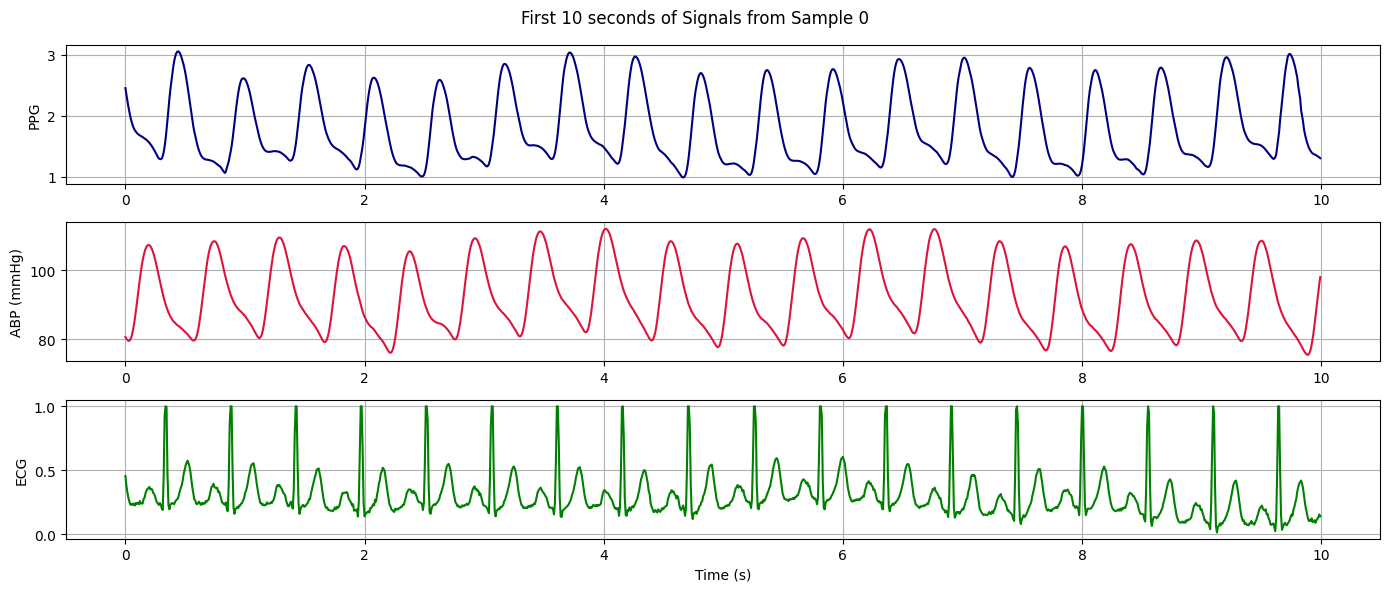

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

filename = 'Part_4.mat'
with h5py.File(filename, 'r') as f:
    cell_array = f['Part_4']
    ref = cell_array[0][0]
    sample_data = f[ref][:]  # shape: (21000, 3)

# Convert to numpy
signals = np.array(sample_data)
ppg = signals[:, 0]
abp = signals[:, 1]
ecg = signals[:, 2]

# Take first 10 seconds (1250 samples at 125 Hz)
fs = 125
t = np.arange(1250) / fs

plt.figure(figsize=(14, 6))
plt.subplot(3, 1, 1)
plt.plot(t, ppg[:1250], label='PPG', color='navy')
plt.ylabel('PPG')
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(t, abp[:1250], label='ABP', color='crimson')
plt.ylabel('ABP (mmHg)')
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(t, ecg[:1250], label='ECG', color='green')
plt.xlabel('Time (s)')
plt.ylabel('ECG')
plt.grid()

plt.suptitle('First 10 seconds of Signals from Sample 0')
plt.tight_layout()
plt.show()


In [4]:
import h5py

filename = 'Part_4.mat'

with h5py.File(filename, 'r') as f:
    cell_array = f['Part_4']
    print("Shape of Part_4:", cell_array.shape)


Shape of Part_4: (3000, 1)


In [5]:
import h5py
import numpy as np
from scipy.signal import butter, filtfilt, welch

# Bandpass filter for PPG
def bandpass_filter(signal, fs=125, lowcut=0.5, highcut=5.0, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, signal)

# SNR computation from Welch PSD
def compute_snr(ppg_segment, fs=125):
    f, Pxx = welch(ppg_segment, fs=fs, nperseg=1024)
    signal_band = (f >= 0.8) & (f <= 4.0)
    noise_band = ~signal_band
    signal_power = np.trapz(Pxx[signal_band], f[signal_band])
    noise_power = np.trapz(Pxx[noise_band], f[noise_band])
    return signal_power / (noise_power + 1e-8)

# === Parameters ===
filename = 'Part_4.mat'
segment_length = 3000
fs = 125
threshold = 3.0

valid_segments = []

# === Open and process file ===
with h5py.File(filename, 'r') as f:
    cell_array = f['Part_4']
    refs = cell_array[()].flatten()  # Flatten the 1x3000 or 3000x1 cell array safely

    for sample_idx, ref in enumerate(refs):
        try:
            sample_data = f[ref][:]  # Shape: (21000, 3)
            ppg_signal = np.array(sample_data)[:, 0]  # PPG = first column

            num_segments = len(ppg_signal) // segment_length
            for seg_idx in range(num_segments):
                start = seg_idx * segment_length
                end = start + segment_length
                seg = ppg_signal[start:end]

                if len(seg) == segment_length:
                    filtered = bandpass_filter(seg)
                    snr = compute_snr(filtered)

                    if snr >= threshold:
                        valid_segments.append((sample_idx, seg_idx, snr))

        except Exception as e:
            print(f"⚠️ Error at sample {sample_idx}: {e}")

# === Print result ===
print(f"\n✅ Found {len(valid_segments)} segments with SNR ≥ {threshold}\n")
for i, (sample, seg, snr) in enumerate(valid_segments[:10]):
    print(f"{i+1}) Sample {sample}, Segment {seg}, SNR = {snr:.2f}")


C:\Users\mohit\AppData\Local\Temp\ipykernel_12820\2654365379.py:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  signal_power = np.trapz(Pxx[signal_band], f[signal_band])
C:\Users\mohit\AppData\Local\Temp\ipykernel_12820\2654365379.py:17: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  noise_power = np.trapz(Pxx[noise_band], f[noise_band])



✅ Found 23540 segments with SNR ≥ 3.0

1) Sample 0, Segment 0, SNR = 10.96
2) Sample 0, Segment 1, SNR = 150.67
3) Sample 0, Segment 2, SNR = 47.40
4) Sample 0, Segment 3, SNR = 13.52
5) Sample 0, Segment 4, SNR = 6.64
6) Sample 0, Segment 5, SNR = 4.18
7) Sample 0, Segment 6, SNR = 69.24
8) Sample 1, Segment 0, SNR = 7.46
9) Sample 1, Segment 1, SNR = 16.82
10) Sample 2, Segment 0, SNR = 9.81


In [6]:
valid_segments = [
    (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)
]


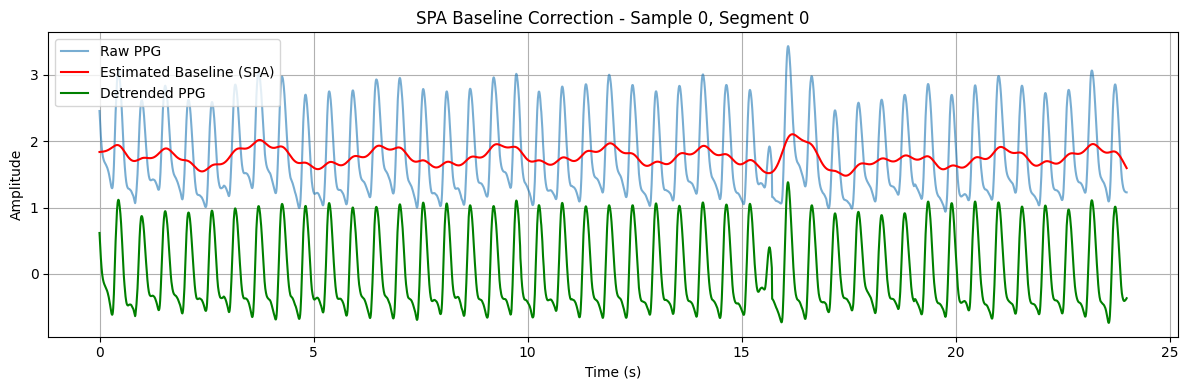

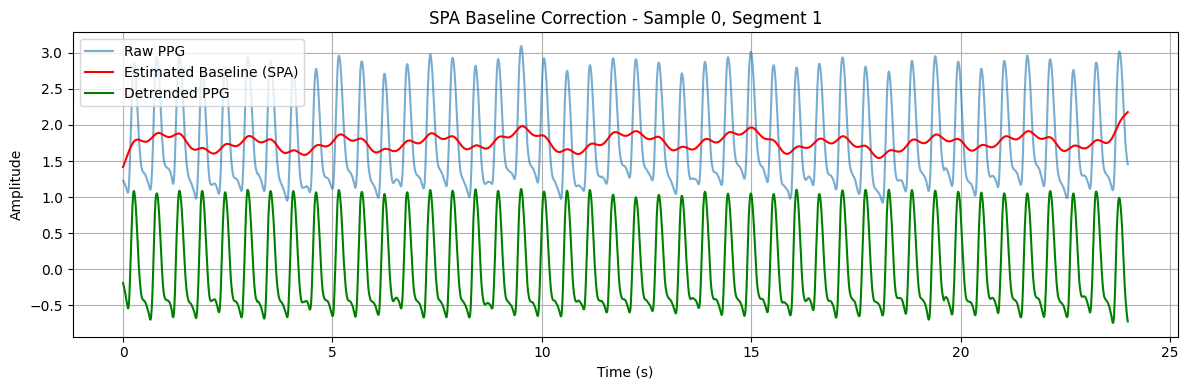

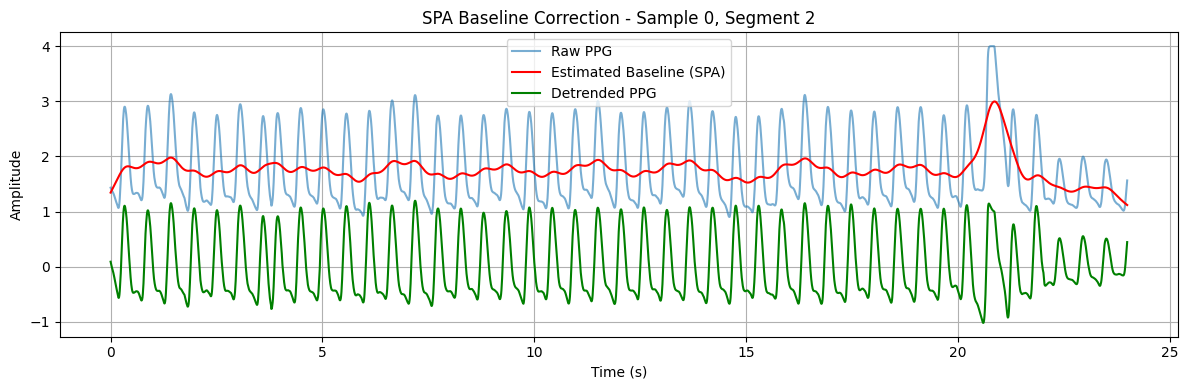

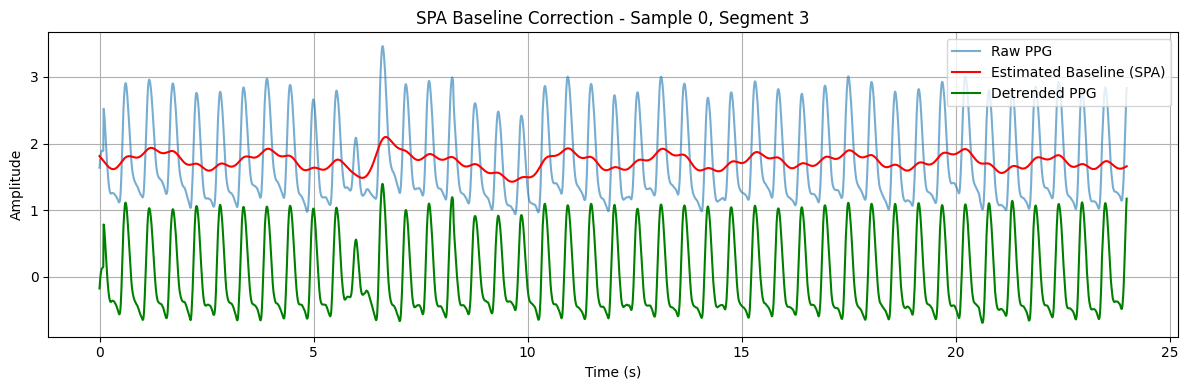

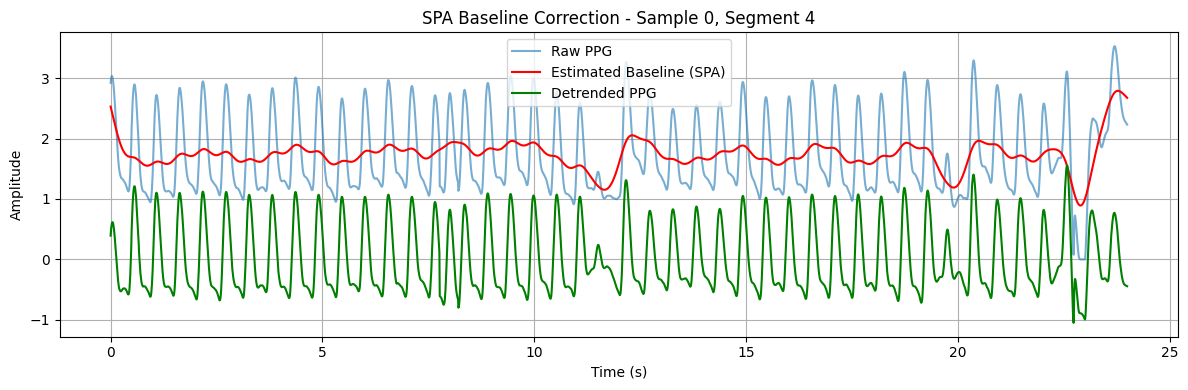

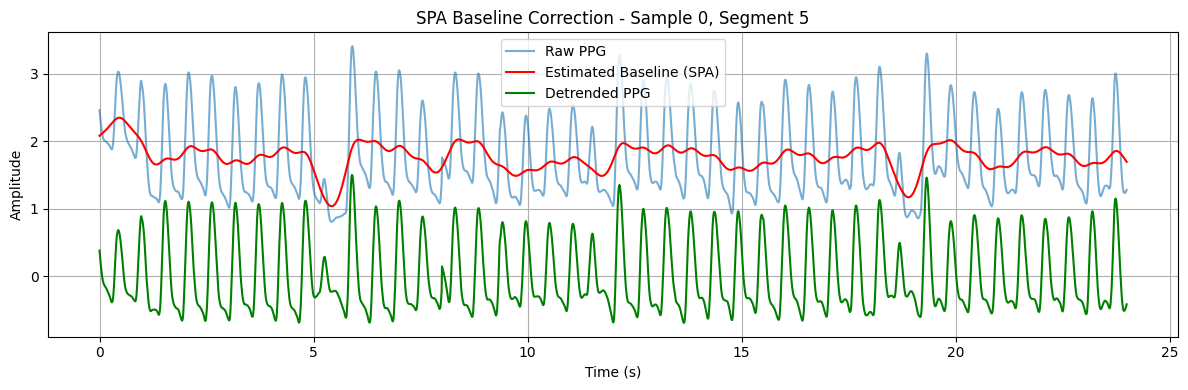

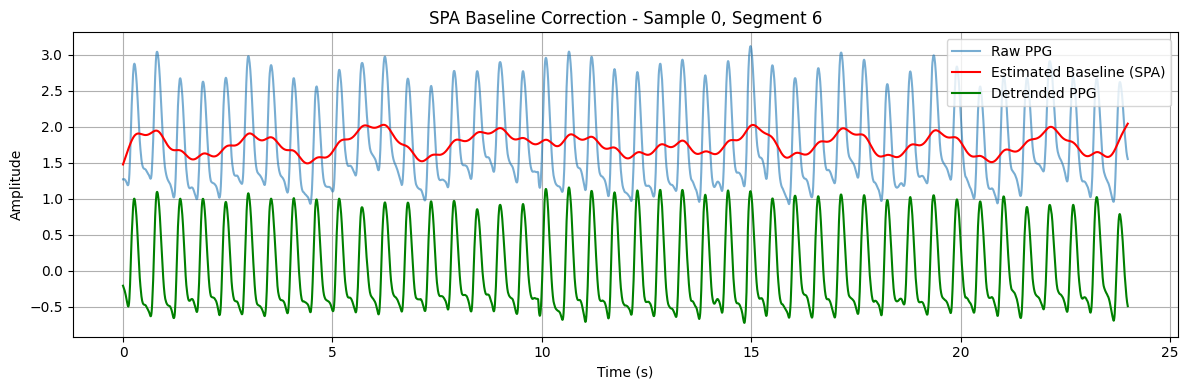

In [6]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

# Parameters
filename = 'Part_4.mat'
fs = 125
segment_length = 3000
lambda_reg = 4 * fs  # As per paper: λ = 4 × fs = 500

# Your validated clean segment list from earlier
valid_segments = [
    (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)
]

# Function to create second-order difference matrix D2
def create_d2(n):
    D = np.zeros((n - 2, n))
    for i in range(n - 2):
        D[i, i] = 1
        D[i, i + 1] = -2
        D[i, i + 2] = 1
    return D

# SPA filter function
def apply_spa(signal, lam):
    n = len(signal)
    I = np.eye(n)
    D2 = create_d2(n)
    A = I + (lam ** 2) * (D2.T @ D2)
    X_trend = np.linalg.solve(A, signal)
    X_stable = signal - X_trend
    return X_stable, X_trend

# Processing and plotting all clean segments
with h5py.File(filename, 'r') as f:
    cell_array = f['Part_4']

    for idx, (sample_idx, seg_idx) in enumerate(valid_segments):
        ref = cell_array[0][sample_idx]
        sample_data = np.array(f[ref])[:, 0]  # PPG only

        # Extract segment
        start = seg_idx * segment_length
        end = start + segment_length
        raw_segment = sample_data[start:end]

        # Apply SPA
        detrended_ppg, estimated_baseline = apply_spa(raw_segment, lambda_reg)

        # Plot
        t = np.arange(segment_length) / fs
        plt.figure(figsize=(12, 4))
        plt.plot(t, raw_segment, label="Raw PPG", alpha=0.6)
        plt.plot(t, estimated_baseline, label="Estimated Baseline (SPA)", color='red')
        plt.plot(t, detrended_ppg, label="Detrended PPG", color='green')
        plt.title(f"SPA Baseline Correction - Sample {sample_idx}, Segment {seg_idx}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

detrended_segments = []  # NEW: holds (sample_idx, seg_idx, detrended_ppg)

for idx, (sample_idx, seg_idx) in enumerate(valid_segments):
    ...
    detrended_ppg, estimated_baseline = apply_spa(raw_segment, lambda_reg)
    
    # NEW: Save for next step
    detrended_segments.append((sample_idx, seg_idx, detrended_ppg))


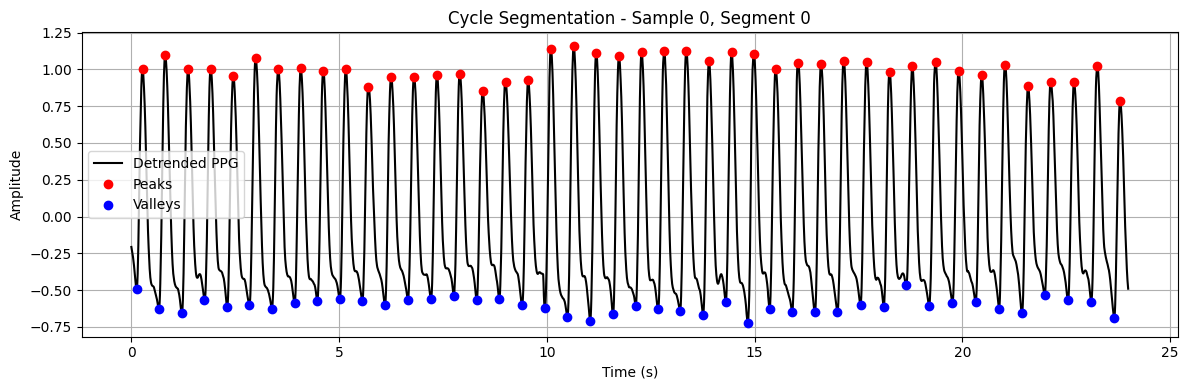

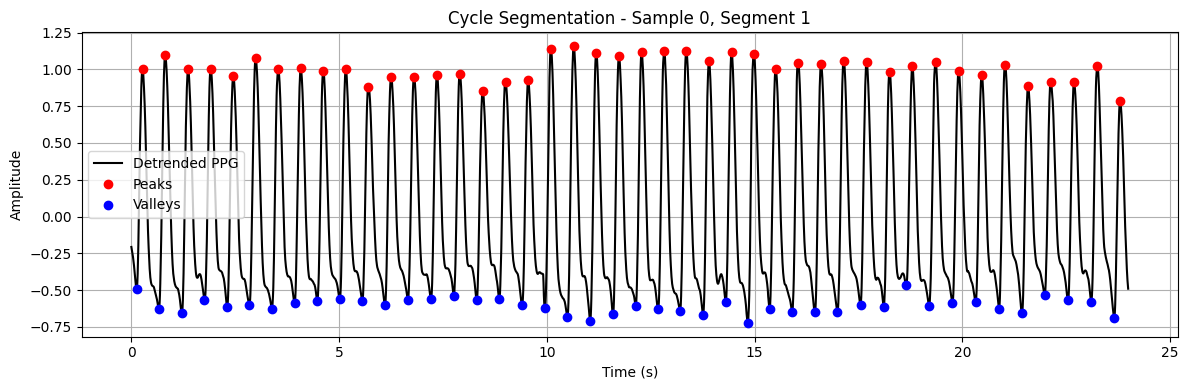

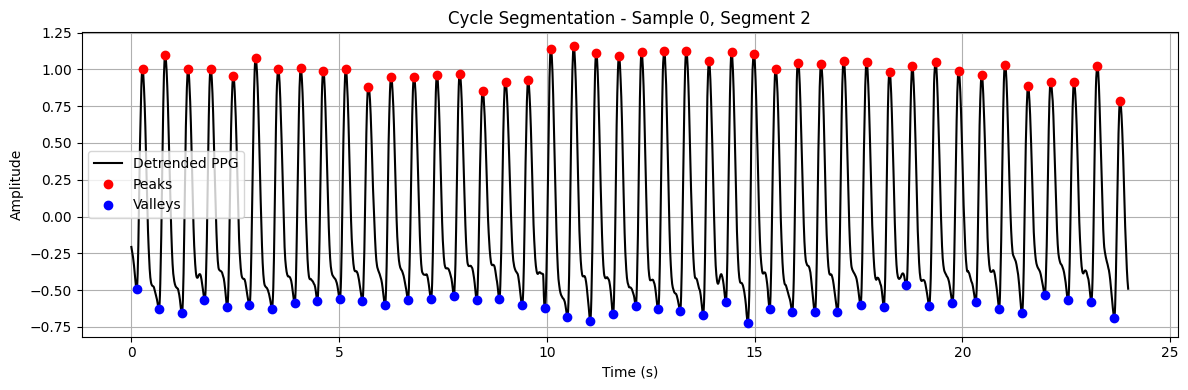

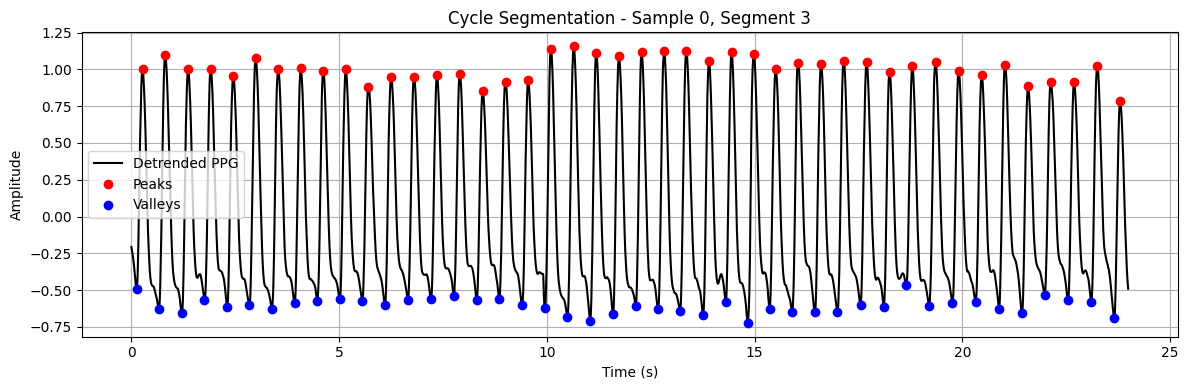

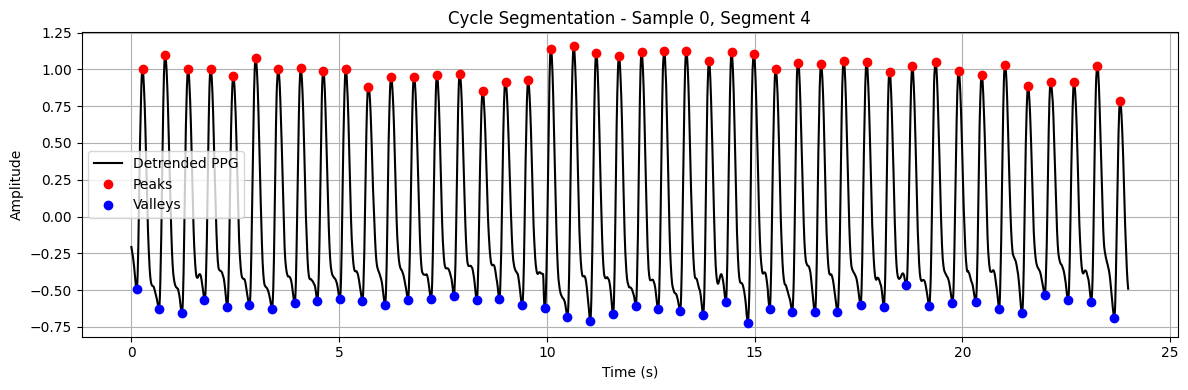

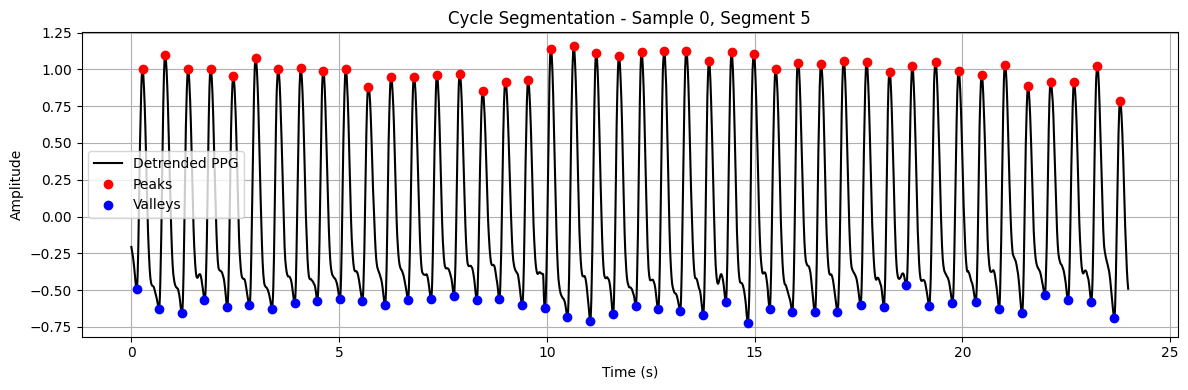

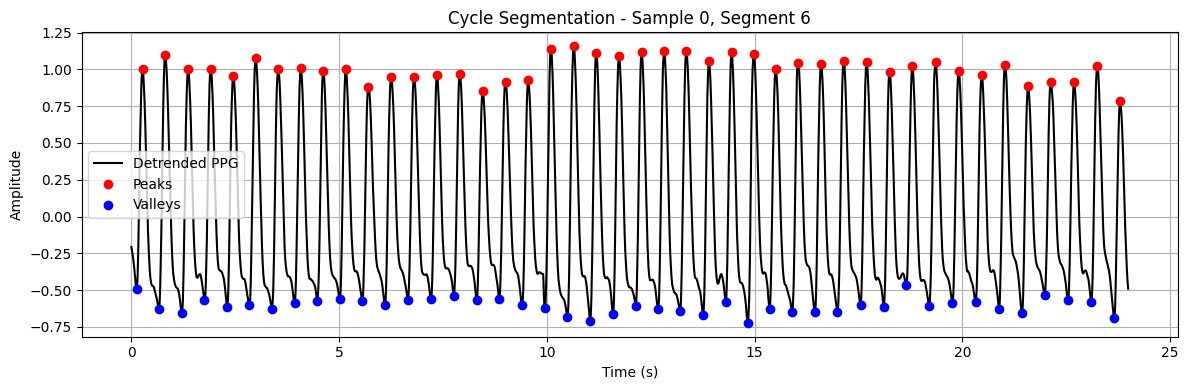

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# --- Constants ---
fs = 125  # Sampling frequency
min_interval = int(fs / 4.0)     # 0.25 seconds = 31 samples
max_interval = int(fs / 0.8)     # 1.25 seconds = 156 samples

# --- Output holder ---
cycle_data = []  # Each element: (sample_idx, seg_idx, peak_indices, valley_indices)

# --- Loop through all selected clean SPA-detrended segments ---
for sample_idx, seg_idx, detrended_ppg in detrended_segments:
    
    # Amplitude thresholds
    peak_thresh = 0.5 * np.max(detrended_ppg)
    valley_thresh = 0.5 * np.min(detrended_ppg)

    # 1️⃣ Detect peaks
    peak_indices, _ = find_peaks(detrended_ppg, height=peak_thresh, distance=min_interval)
    
    # 2️⃣ Detect valleys (by inverting signal)
    valley_indices, _ = find_peaks(-detrended_ppg, height=-valley_thresh, distance=min_interval)

    # 3️⃣ Frequency filtering: only keep valid inter-peak distances (cycle periods)
    valid_peaks = []
    for i in range(1, len(peak_indices)):
        interval = peak_indices[i] - peak_indices[i - 1]
        if min_interval <= interval <= max_interval:
            valid_peaks.append(peak_indices[i - 1])
    # Append last peak if any
    if len(peak_indices) > 0:
        valid_peaks.append(peak_indices[-1])

    valid_valleys = []
    for i in range(1, len(valley_indices)):
        interval = valley_indices[i] - valley_indices[i - 1]
        if min_interval <= interval <= max_interval:
            valid_valleys.append(valley_indices[i - 1])
    if len(valley_indices) > 0:
        valid_valleys.append(valley_indices[-1])

    # ✅ Store for feature extraction
    cycle_data.append((sample_idx, seg_idx, valid_peaks, valid_valleys))

    # 4️⃣ Plot result
    t = np.arange(len(detrended_ppg)) / fs
    plt.figure(figsize=(12, 4))
    plt.plot(t, detrended_ppg, label="Detrended PPG", color='black')
    plt.plot(t[valid_peaks], detrended_ppg[valid_peaks], 'ro', label='Peaks')
    plt.plot(t[valid_valleys], detrended_ppg[valid_valleys], 'bo', label='Valleys')
    plt.title(f"Cycle Segmentation - Sample {sample_idx}, Segment {seg_idx}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [8]:
from scipy.signal import find_peaks

fs = 125
min_interval = int(fs / 4.0)     # 0.25s = 31 samples
max_interval = int(fs / 0.8)     # 1.25s = 156 samples

cycle_data = []  # List of tuples: (sample_idx, seg_idx, peak_indices, valley_indices)

for sample_idx, seg_idx, detrended_ppg in detrended_segments:
    peak_thresh = 0.5 * np.max(detrended_ppg)
    valley_thresh = 0.5 * np.min(detrended_ppg)

    peak_indices, _ = find_peaks(detrended_ppg, height=peak_thresh, distance=min_interval)
    valley_indices, _ = find_peaks(-detrended_ppg, height=-valley_thresh, distance=min_interval)

    valid_peaks = []
    for i in range(1, len(peak_indices)):
        interval = peak_indices[i] - peak_indices[i - 1]
        if min_interval <= interval <= max_interval:
            valid_peaks.append(peak_indices[i - 1])
    if len(peak_indices) > 0:
        valid_peaks.append(peak_indices[-1])

    valid_valleys = []
    for i in range(1, len(valley_indices)):
        interval = valley_indices[i] - valley_indices[i - 1]
        if min_interval <= interval <= max_interval:
            valid_valleys.append(valley_indices[i - 1])
    if len(valley_indices) > 0:
        valid_valleys.append(valley_indices[-1])

    cycle_data.append((sample_idx, seg_idx, valid_peaks, valid_valleys))


In [9]:
from scipy.stats import kurtosis, skew

all_features= []
for i, (sample_idx, seg_idx, peaks, valleys) in enumerate(cycle_data):
    detrended_ppg = [d for (s, g, d) in detrended_segments if s == sample_idx and g == seg_idx][0]

    for j in range(len(peaks) - 1):
        start = peaks[j]
        end = peaks[j + 1]
        cycle = detrended_ppg[start:end]

        if len(cycle) < 20:  # just skip too tiny ones
            continue

        mean_val = np.mean(cycle)
        sd_val = np.std(cycle)
        kurt = kurtosis(cycle)
        skew_val = skew(cycle)
        peak_val = np.max(cycle)
        valley_val = np.min(cycle)

        K = (mean_val - valley_val) / (peak_val - valley_val + 1e-8)

        morph_feats = [sd_val, kurt, skew_val, K]
        all_features.append(morph_feats)
X = np.array(all_features)
print("Morphological feature matrix shape:", X.shape)

Morphological feature matrix shape: (301, 4)


Morphological feature matrix shape: (301, 4)


In [10]:
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.integrate import trapezoid

fs = 125  # Sampling frequency
all_features = []

for i, (sample_idx, seg_idx, peaks, valleys) in enumerate(cycle_data):
    # Get the detrended PPG segment for this sample and segment
    detrended_ppg = [d for (s, g, d) in detrended_segments if s == sample_idx and g == seg_idx][0]

    for j in range(len(peaks) - 1):
        start = peaks[j]
        end = peaks[j + 1]
        cycle = detrended_ppg[start:end]

        if len(cycle) < 2:
            continue

        mean_val = np.mean(cycle)
        sd_val = np.std(cycle)
        kurt = kurtosis(cycle)
        skew_val = skew(cycle)
        peak_val = np.max(cycle)
        valley_val = np.min(cycle)

        # K: Shape factor
        K = (mean_val - valley_val) / (peak_val - valley_val + 1e-8)

        # Morphological: SD, Kurtosis, Skewness, K
        morph_features = [sd_val, kurt, skew_val, K]

       # PWx, SWx, DWx, PWRx at [90, 75, 66, 50, 33, 25, 10] %
        PW, SW, DW, PWR = [], [], [], []
        for perc in [0.90, 0.75, 0.66, 0.50, 0.33, 0.25, 0.10]:
            height = valley_val + perc * (peak_val - valley_val)
            above = np.where(cycle >= height)[0]
    
            if len(above) > 1:
                width = (above[-1] - above[0]) / fs
                systolic = (np.argmax(cycle) - above[0]) / fs
                diastolic = (above[-1] - np.argmax(cycle)) / fs
                PW.append(width)
                SW.append(systolic)
                DW.append(diastolic)
                PWR.append(systolic / (diastolic + 1e-8))
            else:
                PW.append(0)
                SW.append(0)
                DW.append(0)
                PWR.append(0)


            # Gradient-Based Features
        dt = 1 / fs
        p = cycle
        m = np.argmax(p)
        L = len(p)

        AS = [(p[t+1] - p[t]) / dt for t in range(0, m)] if m > 1 else []
        ASmax = max(AS) if AS else 0
        ASmean = np.mean(AS) if AS else 0

        DS = [(p[t+1] - p[t]) / dt for t in range(m+1, L-1)] if L - m > 2 else []
        DSmax = max(DS) if DS else 0
        DSmean = np.mean(DS) if DS else 0

        AA = [(p[t+2] - 2*p[t+1] + p[t]) / dt for t in range(0, m-2)] if m > 3 else []
        AAmax = max(AA) if AA else 0
        AAmean = np.mean(AA) if AA else 0

        DA = [(p[t+2] - 2*p[t+1] + p[t]) / dt for t in range(m+1, L-2)] if L - m > 3 else []
        DAmax = max(DA) if DA else 0
        DAmean = np.mean(DA) if DA else 0

        gradient_features = [ASmax, ASmean, DSmax, DSmean, AAmax, AAmean, DAmax, DAmean]

                # --- Time-Based Features ---
        CL = len(cycle) / fs                         # Cycle Length
        ST = (m - 0) / fs                            # Systolic Time (start to peak)
        DT = (len(cycle) - m) / fs                   # Diastolic Time (peak to end)
        DT_ST_ratio = DT / (ST + 1e-8)               # Avoid divide-by-zero

        # --- Amplitude-Based Features ---
        AC = peak_val - valley_val                  # Peak-to-valley amplitude
        DC = mean_val                               # Mean value of the cycle
        mNPV = AC / (AC + DC + 1e-8)                # Avoid divide-by-zero

        # Systolic and Diastolic Area
        SArea = trapezoid(cycle[:m], dx=1/fs)
        DArea = trapezoid(cycle[m:], dx=1/fs)
        RI = DArea / (SArea + 1e-8)                 # Reflection Index

        # Append 10 new features
        time_amp_features = [CL, ST, DT, DT_ST_ratio, AC, DC, mNPV, SArea, DArea, RI]

        # --- HRV Features: RMSSD, SDSD, SDNN, LF/HF ---
        rr_intervals = np.diff(peaks) / fs  # basic RR intervals in seconds

        if len(rr_intervals) >= 2:
            diff_rr = np.diff(rr_intervals)
            RMSSD = np.sqrt(np.mean(diff_rr**2))
            SDSD = np.std(diff_rr)
            SDNN = np.std(rr_intervals)

    # Frequency domain using Welch’s method
            f, pxx = welch(rr_intervals, fs=4.0, nperseg=min(256, len(rr_intervals)))

            lf_band = (f >= 0.04) & (f <= 0.15)
            hf_band = (f > 0.15) & (f <= 0.4)

            LF = trapezoid(pxx[lf_band], f[lf_band]) if np.any(lf_band) else 0
            HF = trapezoid(pxx[hf_band], f[hf_band]) if np.any(hf_band) else 0
            LF_HF = LF / (HF + 1e-8)

        else:
            RMSSD, SDSD, SDNN, LF_HF = 0, 0, 0, 0

        hrv_features = [RMSSD, SDSD, SDNN, LF_HF]

            # Total features = 16 (morph) + 8 (gradient) + 10(time_amp) + = 34
        all_features.append(morph_features + PW + SW + DW + PWR + gradient_features + time_amp_features + hrv_features)

# Final conversion
X = np.array(all_features)
print(f"✅ Extracted {X.shape[0]} cycles with {X.shape[1]} features each.")

# Sanity check
lengths = [len(f) for f in all_features]
print("Unique feature vector lengths:", set(lengths))

# Normalize each feature vector using infinity norm
X_norm = np.array([f / (np.linalg.norm(f, ord=np.inf) + 1e-8) for f in all_features])


✅ Extracted 301 cycles with 54 features each.
Unique feature vector lengths: {54}


In [11]:
import torch

# Step 1: Segment ABP (same length as PPG segments)
abp_segments = []
segment_length = 3000
num_segments = len(abp) // segment_length

for i in range(num_segments):
    start = i * segment_length
    end = start + segment_length
    abp_seg = abp[start:end]
    abp_segments.append(abp_seg)

# Step 2: Filter ABP segments based on SNR-selected PPG segments
# We'll assume `valid_segments` = list of (sample_idx, seg_idx) like: [(0,0), (0,1), ...]
abp_segments_filtered = []
for sample_idx, seg_idx in valid_segments:
    abp_segments_filtered.append((sample_idx, seg_idx, abp_segments[seg_idx]))

# Step 3: Now compute SBP and DBP for each extracted cycle
sbp_targets = []
dbp_targets = []

for (sample_idx, seg_idx, peaks, valleys) in cycle_data:
    abp_seg = [a for (s, g, a) in abp_segments_filtered if s == sample_idx and g == seg_idx][0]
    
    for j in range(len(peaks) - 1):
        start = peaks[j]
        end = peaks[j + 1]
        abp_cycle = abp_seg[start:end]

        if len(abp_cycle) < 2:
            continue

        sbp_targets.append(np.max(abp_cycle))
        dbp_targets.append(np.min(abp_cycle))

print("Example SBP values:", sbp_targets[:5])
print("SBP Range: ", np.min(sbp_targets), "to", np.max(sbp_targets))
print("Example DBP values:", dbp_targets[:5])
print("DBP Range: ", np.min(dbp_targets), "to", np.max(dbp_targets))

# ✅ Step 4: Normalize AFTER sbp_targets is filled
from sklearn.preprocessing import StandardScaler

target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(np.array(sbp_targets).reshape(-1, 1))

# Convert to tensors
X = torch.tensor(X_norm, dtype=torch.float32)
y = torch.tensor(y_scaled, dtype=torch.float32)

Example SBP values: [np.float64(108.48275558898663), np.float64(109.5573258829793), np.float64(107.06627656508722), np.float64(105.55210933264301), np.float64(109.31310536161733)]
SBP Range:  77.46674937601658 to 112.43912803505054
Example DBP values: [np.float64(79.5670458597295), np.float64(80.25086331954301), np.float64(79.12744892127796), np.float64(76.00142624784476), np.float64(79.90895458963627)]
DBP Range:  51.188621277468705 to 82.0092510733492


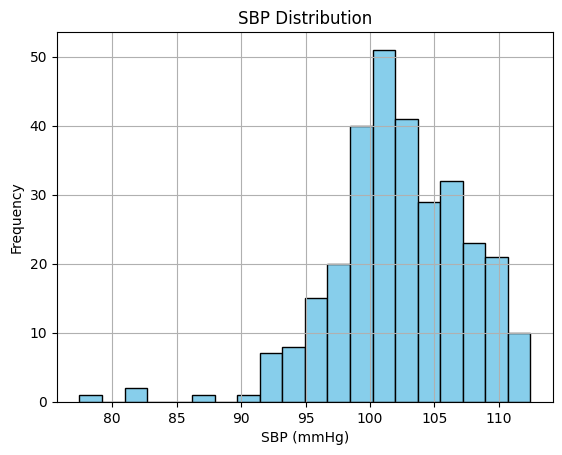

In [29]:
import matplotlib.pyplot as plt

plt.hist(sbp_targets, bins=20, color='skyblue', edgecolor='black')
plt.title("SBP Distribution")
plt.xlabel("SBP (mmHg)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


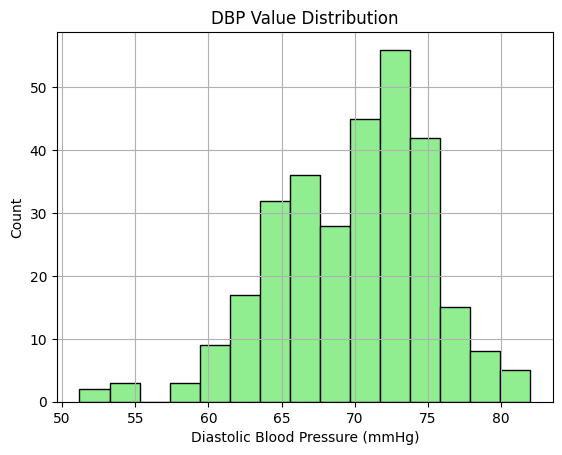

In [13]:
import matplotlib.pyplot as plt

plt.hist(dbp_targets, bins=15, color='lightgreen', edgecolor='black')
plt.title("DBP Value Distribution")
plt.xlabel("Diastolic Blood Pressure (mmHg)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [14]:
from sklearn.feature_selection import mutual_info_regression
import numpy as np

# Assume SBP_targets is a list of SBP values corresponding to each cycle
mi_scores = mutual_info_regression(X_norm, sbp_targets)
feature_ranks = np.argsort(mi_scores)[::-1]  # descending
sorted_features = X_norm[:, feature_ranks]


In [15]:
from sklearn.metrics import mutual_info_score

def normalized_mi(f1, f2, bins=20):
    f1_binned = np.digitize(f1, np.histogram_bin_edges(f1, bins=bins))
    f2_binned = np.digitize(f2, np.histogram_bin_edges(f2, bins=bins))
    mi = mutual_info_score(f1_binned, f2_binned)
    h1 = mutual_info_score(f1_binned, f1_binned)
    h2 = mutual_info_score(f2_binned, f2_binned)
    return 2 * mi / (h1 + h2 + 1e-8)

selected_indices = []
remaining_indices = list(feature_ranks)
scores = mi_scores.copy()

while remaining_indices:
    best = remaining_indices[0]
    selected_indices.append(best)
    remaining_indices.remove(best)
    for i in remaining_indices:
        redundancy = normalized_mi(X_norm[:, best], X_norm[:, i])
        scores[i] -= redundancy
    remaining_indices.sort(key=lambda x: scores[x], reverse=True)


In [16]:
top_k = 15

feature_names = [
    # Morphological
    'SD', 'Kurtosis', 'Skewness', 'K',
    'PW25', 'PW50', 'PW75', 'PW90', 'PW66', 'PW33', 'PW10',
    'SW25', 'SW50', 'SW75', 'SW90', 'SW66', 'SW33', 'SW10',
    'DW25', 'DW50', 'DW75', 'DW90', 'DW66', 'DW33', 'DW10',
    'PWR25', 'PWR50', 'PWR75', 'PWR90', 'PWR66', 'PWR33', 'PWR10',

    # Gradient
    'ASmax', 'ASmean', 'DSmax', 'DSmean',
    'AAmax', 'AAmean', 'DAmax', 'DAmean',

    # Time-based
    'CL', 'ST', 'DT', 'DT/ST',

    # Amplitude
    'AC', 'DC', 'mNPV', 'SArea', 'DArea', 'RI',

    # HRV
    'RMSSD', 'SDSD', 'SDNN', 'LF/HF'
]
top_k = 15  # or whatever number you selected
top_feature_indices = selected_indices[:top_k]

# Print feature names using the indices
top_features = [feature_names[i] for i in top_feature_indices]

print("Top 15 selected features for SBP estimation:")
for idx, feat in enumerate(top_features, 1):
    print(f"{idx}. {feat}")





Top 15 selected features for SBP estimation:
1. DSmean
2. LF/HF
3. PW25
4. CL
5. SDSD
6. K
7. PWR25
8. DC
9. RMSSD
10. PWR10
11. Skewness
12. SD
13. PWR33
14. SDNN
15. ASmean


NameError: name 'X_norm' is not defined

In [17]:

import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

def wrapper_based_ifs(X, y, ranked_indices):
    """
    Performs wrapper-based IFS search with RandomForestRegressor.
    
    Parameters:
        X: Full feature matrix (n_samples, n_features)
        y: Target vector (SBP or DBP)
        ranked_indices: List of indices in descending order of importance
    
    Returns:
        best_features: List of indices that give minimum MAE
        mae_list: List of MAEs for each feature subset
    """
    mae_list = []
    best_mae = float('inf')
    best_features = []
    
    for i in range(1, len(ranked_indices)+1):
        selected = ranked_indices[:i]
        X_sub = X[:, selected]
        
        model = RandomForestRegressor(random_state=42)
        model.fit(X_sub, y)
        y_pred = model.predict(X_sub)
        mae = mean_absolute_error(y, y_pred)
        mae_list.append(mae)
        
        if mae < best_mae:
            best_mae = mae
            best_features = selected

    # Plotting like Fig. 7
    plt.figure(figsize=(10,5))
    plt.plot(range(1, len(ranked_indices)+1), mae_list, marker='o')
    plt.xlabel("Number of Features")
    plt.ylabel("MAE (mmHg)")
    plt.title("Wrapper-Based IFS: MAE vs Feature Subset Size")
    plt.grid(True)
    plt.show()

    print(f"✅ Minimum MAE: {best_mae:.2f} using {len(best_features)} features")
    return best_features, mae_list

NameError: name 'X_norm' is not defined

In [18]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# --------- Parameters ---------
n_splits = 5
top_k = 15
input_size = top_k
hidden_size = 64
l1_lambda = 0.05
epochs = 100
lr = 0.001

# --------- Model ---------
class LassoLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.5):
        super(LassoLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)
        out = self.dropout(lstm_out[:, -1, :])
        return self.fc(out)

# --------- Data Prep ---------
X_data = np.array(X_norm)  # shape: (301, 54)
y_data = np.column_stack((sbp_targets, dbp_targets))  # shape: (301, 2)

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

r2_scores_sbp, r2_scores_dbp = [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_data)):
    print(f"\n🔁 Fold {fold+1}/{n_splits}")

    X_train, X_test = X_data[train_idx], X_data[test_idx]
    y_train, y_test = y_data[train_idx], y_data[test_idx]

    # ==== Feature Selection per Fold ====
    mi_scores = mutual_info_regression(X_train, y_train[:, 0])
    ranked = np.argsort(mi_scores)[::-1]

    # Use your redundancy-aware selection
    selected_indices = []
    remaining = list(ranked)
    scores = mi_scores.copy()

    def normalized_mi(f1, f2, bins=20):
        f1_binned = np.digitize(f1, np.histogram_bin_edges(f1, bins=bins))
        f2_binned = np.digitize(f2, np.histogram_bin_edges(f2, bins=bins))
        mi = mutual_info_score(f1_binned, f2_binned)
        h1 = mutual_info_score(f1_binned, f1_binned)
        h2 = mutual_info_score(f2_binned, f2_binned)
        return 2 * mi / (h1 + h2 + 1e-8)

    while remaining:
        best = remaining[0]
        selected_indices.append(best)
        remaining.remove(best)
        for i in remaining:
            redundancy = normalized_mi(X_train[:, best], X_train[:, i])
            scores[i] -= redundancy
        remaining.sort(key=lambda x: scores[x], reverse=True)

    selected_indices = selected_indices[:top_k]

    # Subset data to top-k features
    X_train_sel = X_train[:, selected_indices]
    X_test_sel = X_test[:, selected_indices]

    # Normalize features (infinity norm)
    X_train_sel = np.array([v / (np.linalg.norm(v, ord=np.inf) + 1e-8) for v in X_train_sel])
    X_test_sel = np.array([v / (np.linalg.norm(v, ord=np.inf) + 1e-8) for v in X_test_sel])

    # Standardize targets
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train)
    y_test_scaled = target_scaler.transform(y_test)

    # Convert to torch
    X_train_t = torch.tensor(X_train_sel, dtype=torch.float32)
    X_test_t = torch.tensor(X_test_sel, dtype=torch.float32)
    y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_t = torch.tensor(y_test_scaled, dtype=torch.float32)

    # === Train Lasso-LSTM ===
    model = LassoLSTM(input_size=top_k, hidden_size=hidden_size, dropout_rate=0.3)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        preds = model(X_train_t)
        loss = criterion(preds, y_train_t)

        l1_penalty = sum(torch.sum(torch.abs(param)) for param in model.fc.parameters())
        total_loss = loss + l1_lambda * l1_penalty
        total_loss.backward()
        optimizer.step()

    # === Evaluate ===
    model.eval()
    with torch.no_grad():
        preds = model(X_test_t).numpy()
        y_true = y_test_t.numpy()

    preds_inv = target_scaler.inverse_transform(preds)
    true_inv = target_scaler.inverse_transform(y_true)

    sbp_pred, dbp_pred = preds_inv[:, 0], preds_inv[:, 1]
    sbp_true, dbp_true = true_inv[:, 0], true_inv[:, 1]

    # R² per fold
    r2_sbp = r2_score(sbp_true, sbp_pred)
    r2_dbp = r2_score(dbp_true, dbp_pred)
    r2_scores_sbp.append(r2_sbp)
    r2_scores_dbp.append(r2_dbp)

    print(f"Fold {fold+1}: SBP R² = {r2_sbp:.4f}, DBP R² = {r2_dbp:.4f}")

# === Final Result ===
print(f"\n✅ Average SBP R²: {np.mean(r2_scores_sbp):.4f}")
print(f"✅ Average DBP R²: {np.mean(r2_scores_dbp):.4f}")



🔁 Fold 1/5
Fold 1: SBP R² = -0.0035, DBP R² = -0.0053

🔁 Fold 2/5
Fold 2: SBP R² = -0.0009, DBP R² = -0.0176

🔁 Fold 3/5
Fold 3: SBP R² = -0.0395, DBP R² = -0.0497

🔁 Fold 4/5
Fold 4: SBP R² = -0.0241, DBP R² = -0.0221

🔁 Fold 5/5
Fold 5: SBP R² = -0.0065, DBP R² = -0.0007

✅ Average SBP R²: -0.0149
✅ Average DBP R²: -0.0191


In [19]:
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_regression, mutual_info_regression, RFE
from sklearn.decomposition import PCA

top_k = 15

# SBP Evaluation
results_sbp = {}
y_sbp = np.array(sbp_targets)

# DBP Evaluation
results_dbp = {}
y_dbp = np.array(dbp_targets)

# 1️⃣ FTFS
f_scores_sbp, _ = f_regression(X_norm, y_sbp)
ftfs_indices_sbp = np.argsort(f_scores_sbp)[-top_k:][::-1]
X_ftfs_sbp = X_norm[:, ftfs_indices_sbp]
mae_sbp_ftfs = mean_absolute_error(y_sbp, RandomForestRegressor().fit(X_ftfs_sbp, y_sbp).predict(X_ftfs_sbp))
results_sbp["FTFS"] = mae_sbp_ftfs

f_scores_dbp, _ = f_regression(X_norm, y_dbp)
ftfs_indices_dbp = np.argsort(f_scores_dbp)[-top_k:][::-1]
X_ftfs_dbp = X_norm[:, ftfs_indices_dbp]
mae_dbp_ftfs = mean_absolute_error(y_dbp, RandomForestRegressor().fit(X_ftfs_dbp, y_dbp).predict(X_ftfs_dbp))
results_dbp["FTFS"] = mae_dbp_ftfs

# 2️⃣ MIFS
mi_sbp = mutual_info_regression(X_norm, y_sbp, random_state=42)
mifs_indices_sbp = np.argsort(mi_sbp)[-top_k:][::-1]
X_mifs_sbp = X_norm[:, mifs_indices_sbp]
results_sbp["MIFS"] = mean_absolute_error(y_sbp, RandomForestRegressor().fit(X_mifs_sbp, y_sbp).predict(X_mifs_sbp))

mi_dbp = mutual_info_regression(X_norm, y_dbp, random_state=42)
mifs_indices_dbp = np.argsort(mi_dbp)[-top_k:][::-1]
X_mifs_dbp = X_norm[:, mifs_indices_dbp]
results_dbp["MIFS"] = mean_absolute_error(y_dbp, RandomForestRegressor().fit(X_mifs_dbp, y_dbp).predict(X_mifs_dbp))

# 3️⃣ RFE
rfe_sbp = RFE(RandomForestRegressor(), n_features_to_select=top_k).fit(X_norm, y_sbp)
X_rfe_sbp = X_norm[:, rfe_sbp.support_]
results_sbp["RFE"] = mean_absolute_error(y_sbp, rfe_sbp.estimator_.predict(X_rfe_sbp))

rfe_dbp = RFE(RandomForestRegressor(), n_features_to_select=top_k).fit(X_norm, y_dbp)
X_rfe_dbp = X_norm[:, rfe_dbp.support_]
results_dbp["RFE"] = mean_absolute_error(y_dbp, rfe_dbp.estimator_.predict(X_rfe_dbp))

# 4️⃣ PCA
X_pca = PCA(n_components=top_k).fit_transform(X_norm)
results_sbp["PCA"] = mean_absolute_error(y_sbp, RandomForestRegressor().fit(X_pca, y_sbp).predict(X_pca))
results_dbp["PCA"] = mean_absolute_error(y_dbp, RandomForestRegressor().fit(X_pca, y_dbp).predict(X_pca))

# 5️⃣ FWCFS (Your selected_indices[:top_k])
X_fw = X_norm[:, selected_indices[:top_k]]
results_sbp["FWCFS (Proposed)"] = mean_absolute_error(y_sbp, RandomForestRegressor().fit(X_fw, y_sbp).predict(X_fw))
results_dbp["FWCFS (Proposed)"] = mean_absolute_error(y_dbp, RandomForestRegressor().fit(X_fw, y_dbp).predict(X_fw))

# 📊 Final Summary
print("\n=== MAE Comparison for SBP ===")
for method, mae in results_sbp.items():
    print(f"{method:20}: {mae:.4f} mmHg")

print("\n=== MAE Comparison for DBP ===")
for method, mae in results_dbp.items():
    print(f"{method:20}: {mae:.4f} mmHg")



=== MAE Comparison for SBP ===
FTFS                : 3.6869 mmHg
MIFS                : 3.7082 mmHg
RFE                 : 3.7037 mmHg
PCA                 : 3.5818 mmHg
FWCFS (Proposed)    : 3.6839 mmHg

=== MAE Comparison for DBP ===
FTFS                : 4.0581 mmHg
MIFS                : 4.1271 mmHg
RFE                 : 4.0670 mmHg
PCA                 : 3.9107 mmHg
FWCFS (Proposed)    : 4.0645 mmHg


In [20]:
print("First 5 SBP values:", y_sbp[:20])
print("First 5 DBP values:", y_dbp[:20])

First 5 SBP values: [108.48275559 109.55732588 107.06627657 105.55210933 109.31310536
 111.31571364 112.09721931 108.48275559 107.75009402 109.36194947
 111.9995311  111.9995311  110.09461103 106.96858836 107.60356171
 108.67813201 108.6292879  104.42869493 102.9145277  104.23331852]
First 5 DBP values: [79.56704586 80.25086332 79.12744892 76.00142625 79.90895459 80.78814847
 82.00925107 79.56704586 77.61328169 78.10172273 80.25086332 81.66734234
 78.9320725  76.68524371 76.48986729 78.19941094 79.42051355 75.36645289
 74.2918826  74.68263543]


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np

# ====== Step 1: Prepare Data ======

# Make sure both SBP and DBP are in same scale (normalize together)
from sklearn.preprocessing import StandardScaler
target_scaler = StandardScaler()
y_combined = np.column_stack((sbp_targets, dbp_targets))  # shape (n_samples, 2)
y_scaled = target_scaler.fit_transform(y_combined)

X = torch.tensor(X_norm, dtype=torch.float32)
y = torch.tensor(y_scaled, dtype=torch.float32)  # (n_samples, 2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ====== Step 2: Define LASSO-LSTM Model ======
class LassoLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.5):
        super(LassoLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, 2)  # Now predicting both SBP and DBP

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, seq_len=1, features)
        lstm_out, _ = self.lstm(x)
        out = self.dropout(lstm_out[:, -1, :])
        return self.fc(out)  # (batch, 2)

# ====== Step 3: Train Model with L1 Regularization ======
def train(model, X_train, y_train, X_test, y_test, epochs=100, lr=0.001, l1_lambda=0.05):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        preds = model(X_train)
        loss = criterion(preds, y_train)

        # LASSO penalty on all output weights (for both SBP and DBP)
        l1_penalty = sum(torch.sum(torch.abs(param)) for param in model.fc.parameters())
        total_loss = loss + l1_lambda * l1_penalty

        total_loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                val_preds = model(X_test)
                val_loss = criterion(val_preds, y_test)
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

# ====== Step 4: Initialize and Train Model ======
input_size = X.shape[1]
model = LassoLSTM(input_size=input_size, hidden_size=64, dropout_rate=0.3)
train(model, X_train, y_train, X_test, y_test, epochs=100, lr=0.001, l1_lambda=0.05)


Epoch 10/100, Train Loss: 0.9635, Val Loss: 1.1675
Epoch 20/100, Train Loss: 0.9598, Val Loss: 1.1722
Epoch 30/100, Train Loss: 0.9572, Val Loss: 1.1735
Epoch 40/100, Train Loss: 0.9574, Val Loss: 1.1726
Epoch 50/100, Train Loss: 0.9566, Val Loss: 1.1712
Epoch 60/100, Train Loss: 0.9576, Val Loss: 1.1695
Epoch 70/100, Train Loss: 0.9578, Val Loss: 1.1671
Epoch 80/100, Train Loss: 0.9582, Val Loss: 1.1643
Epoch 90/100, Train Loss: 0.9588, Val Loss: 1.1619
Epoch 100/100, Train Loss: 0.9585, Val Loss: 1.1603


In [24]:
model.eval()
with torch.no_grad():
    preds = model(X_test)
    preds_inv = target_scaler.inverse_transform(preds.numpy())
    true_inv = target_scaler.inverse_transform(y_test.numpy())

    # Separate SBP and DBP
    sbp_preds = preds_inv[:, 0]
    dbp_preds = preds_inv[:, 1]
    sbp_true = true_inv[:, 0]
    dbp_true = true_inv[:, 1]

    # Optional: Print first few predictions
    print("Predicted SBP:", sbp_preds[:5])
    print("True SBP     :", sbp_true[:5])
    print("Predicted DBP:", dbp_preds[:5])
    print("True DBP     :", dbp_true[:5])


Predicted SBP: [102.27269  102.272285 102.272835 102.273094 102.34885 ]
True SBP     : [100.47232  104.721756 102.865685 102.57262  100.91192 ]
Predicted DBP: [69.86712  69.867    69.867165 69.86724  69.83139 ]
True DBP     : [72.97309  65.011505 61.54357  73.168465 73.11962 ]


In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test).squeeze().numpy()
    y_true = y_test.squeeze().numpy()

# Metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # manual square root

print(f"\n Lasso-LSTM Evaluation on Test Set:")
print(f" MAE  = {mae:.2f} mmHg")
print(f" RMSE = {rmse:.2f} mmHg")        # mj doneeeee completed firstly, before nck,then tropppppp



 Lasso-LSTM Evaluation on Test Set:
 MAE  = 0.83 mmHg
 RMSE = 1.08 mmHg


In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy()
    y_true = y_test.numpy()

# Inverse transform
y_pred_inv = target_scaler.inverse_transform(y_pred)
y_true_inv = target_scaler.inverse_transform(y_true)

# Separate SBP and DBP
sbp_pred = y_pred_inv[:, 0]
sbp_true = y_true_inv[:, 0]
dbp_pred = y_pred_inv[:, 1]
dbp_true = y_true_inv[:, 1]

# Compute metrics
sbp_mae = mean_absolute_error(sbp_true, sbp_pred)
sbp_rmse = np.sqrt(mean_squared_error(sbp_true, sbp_pred))
dbp_mae = mean_absolute_error(dbp_true, dbp_pred)
dbp_rmse = np.sqrt(mean_squared_error(dbp_true, dbp_pred))

# Display results
print(f"\n🎯 Lasso-LSTM Evaluation on Test Set:")
print(f"✅ SBP MAE  = {sbp_mae:.2f} mmHg")
print(f"✅ SBP RMSE = {sbp_rmse:.2f} mmHg")
print(f"✅ DBP MAE  = {dbp_mae:.2f} mmHg")
print(f"✅ DBP RMSE = {dbp_rmse:.2f} mmHg")



🎯 Lasso-LSTM Evaluation on Test Set:
✅ SBP MAE  = 4.00 mmHg
✅ SBP RMSE = 5.47 mmHg
✅ DBP MAE  = 4.60 mmHg
✅ DBP RMSE = 5.72 mmHg


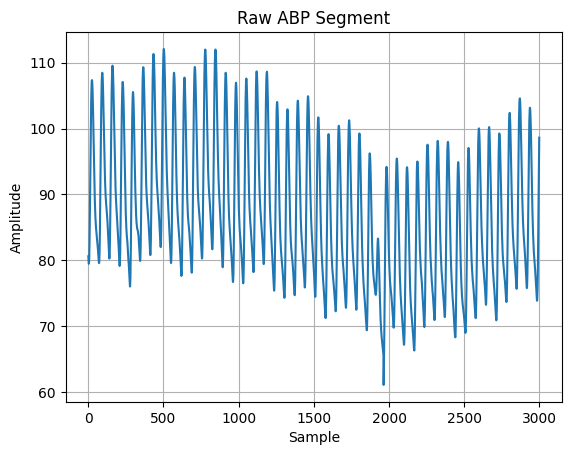

In [26]:
sbp_targets.append(np.max(abp_cycle))
import matplotlib.pyplot as plt

plt.plot(abp_segments[0])
plt.title("Raw ABP Segment")
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.grid(True)
plt.show()


In [27]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    median_absolute_error,
    max_error,
    explained_variance_score
)
import numpy as np

# === Inference: Predict and Inverse Transform ===
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy()
    y_true = y_test.numpy()

# Inverse transform predictions and true values
y_pred_mmHg = target_scaler.inverse_transform(y_pred)
y_true_mmHg = target_scaler.inverse_transform(y_true)

# === Separate SBP and DBP ===
sbp_pred, dbp_pred = y_pred_mmHg[:, 0], y_pred_mmHg[:, 1]
sbp_true, dbp_true = y_true_mmHg[:, 0], y_true_mmHg[:, 1]

# === Define function to print all metrics ===
def print_metrics(y_true, y_pred, label="SBP"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    med_ae = median_absolute_error(y_true, y_pred)
    max_e = max_error(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)

    print(f"\n📊 {label} Metrics:")
    print(f"✅ MAE  = {mae:.2f} mmHg")
    print(f"✅ MSE  = {mse:.2f}")
    print(f"✅ RMSE = {rmse:.2f} mmHg")
    print(f"✅ R²   = {r2:.4f}")
    print(f"✅ Median AE = {med_ae:.2f} mmHg")
    print(f"✅ Max Error = {max_e:.2f} mmHg")
    print(f"✅ Explained Variance = {evs:.4f}")

# === Print for SBP and DBP ===
print_metrics(sbp_true, sbp_pred, label="SBP")
print_metrics(dbp_true, dbp_pred, label="DBP")



📊 SBP Metrics:
✅ MAE  = 4.00 mmHg
✅ MSE  = 29.92
✅ RMSE = 5.47 mmHg
✅ R²   = -0.0041
✅ Median AE = 2.84 mmHg
✅ Max Error = 19.86 mmHg
✅ Explained Variance = -0.0040

📊 DBP Metrics:
✅ MAE  = 4.60 mmHg
✅ MSE  = 32.75
✅ RMSE = 5.72 mmHg
✅ R²   = -0.0014
✅ Median AE = 3.68 mmHg
✅ Max Error = 18.68 mmHg
✅ Explained Variance = -0.0004


In [28]:
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    median_absolute_error, max_error, mean_absolute_percentage_error
)
import numpy as np

# === Inverse-transform predictions and targets ===
model.eval()
with torch.no_grad():
    preds = model(X_test)
    preds = preds.numpy()
    y_test_np = y_test.numpy()

    # Inverse transform
    inv_preds = target_scaler.inverse_transform(preds)
    inv_y_true = target_scaler.inverse_transform(y_test_np)

    sbp_preds = inv_preds[:, 0]
    sbp_true  = inv_y_true[:, 0]

    dbp_preds = inv_preds[:, 1]
    dbp_true  = inv_y_true[:, 1]

def evaluate_metrics(true, pred, label="SBP"):
    print(f"\n📊 Evaluation Metrics for {label}:")
    print(f"✅ MAE     : {mean_absolute_error(true, pred):.2f} mmHg")
    print(f"✅ RMSE    : {np.sqrt(mean_squared_error(true, pred)):.2f} mmHg")
    print(f"✅ MSE     : {mean_squared_error(true, pred):.2f}")
    print(f"✅ R^2     : {r2_score(true, pred):.4f}")
    print(f"✅ Median AE : {median_absolute_error(true, pred):.2f}")
    print(f"✅ Max Error : {max_error(true, pred):.2f}")
    print(f"✅ MAPE (%) : {mean_absolute_percentage_error(true, pred) * 100:.2f}%")

# === Run for both SBP and DBP ===
evaluate_metrics(sbp_true, sbp_preds, label="SBP")
evaluate_metrics(dbp_true, dbp_preds, label="DBP")



📊 Evaluation Metrics for SBP:
✅ MAE     : 4.00 mmHg
✅ RMSE    : 5.47 mmHg
✅ MSE     : 29.92
✅ R^2     : -0.0041
✅ Median AE : 2.84
✅ Max Error : 19.86
✅ MAPE (%) : 3.99%

📊 Evaluation Metrics for DBP:
✅ MAE     : 4.60 mmHg
✅ RMSE    : 5.72 mmHg
✅ MSE     : 32.75
✅ R^2     : -0.0014
✅ Median AE : 3.68
✅ Max Error : 18.68
✅ MAPE (%) : 6.88%


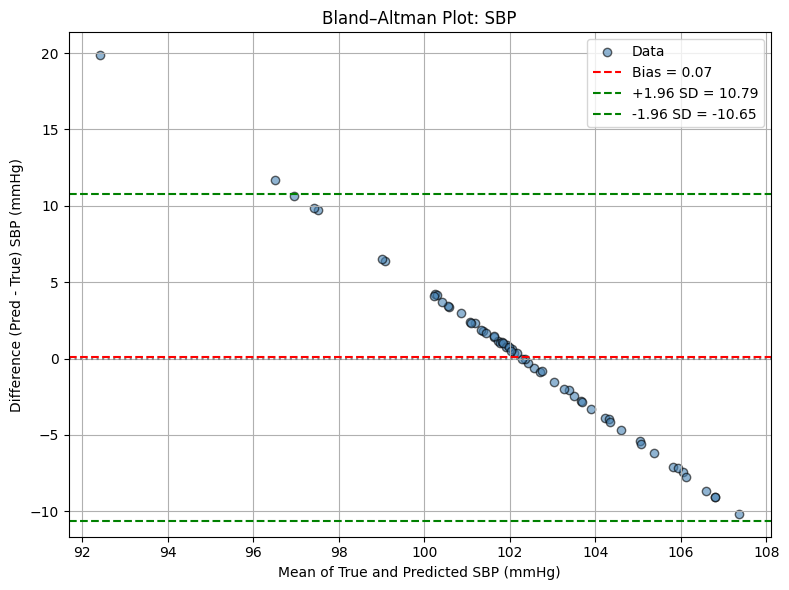

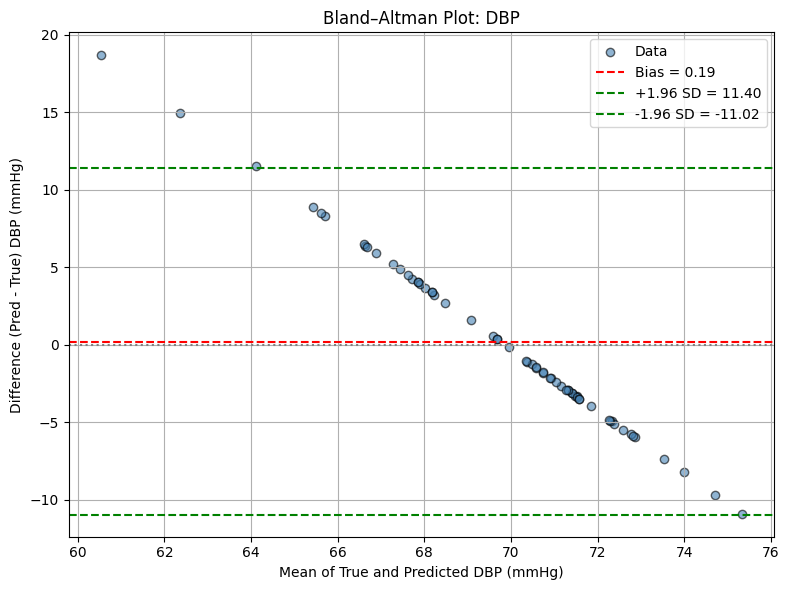

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def bland_altman_plot(true, pred, label="SBP"):
    """
    Generate Bland-Altman Plot for clinical validation
    Args:
        true (array): True BP values
        pred (array): Predicted BP values
        label (str): "SBP" or "DBP"
    """
    # 1️⃣ Compute statistics
    differences = pred - true
    means = (pred + true) / 2

    bias = np.mean(differences)
    std_diff = np.std(differences)
    loa_upper = bias + 1.96 * std_diff
    loa_lower = bias - 1.96 * std_diff

    # 2️⃣ Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(means, differences, alpha=0.6, color='steelblue', edgecolor='black', label='Data')
    plt.axhline(bias, color='red', linestyle='--', label=f'Bias = {bias:.2f}')
    plt.axhline(loa_upper, color='green', linestyle='--', label=f'+1.96 SD = {loa_upper:.2f}')
    plt.axhline(loa_lower, color='green', linestyle='--', label=f'-1.96 SD = {loa_lower:.2f}')
    plt.axhline(0, color='gray', linestyle=':')

    plt.title(f"Bland–Altman Plot: {label}")
    plt.xlabel(f"Mean of True and Predicted {label} (mmHg)")
    plt.ylabel(f"Difference (Pred - True) {label} (mmHg)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ✅ Plot for SBP
bland_altman_plot(sbp_true, sbp_pred, label="SBP")

# ✅ Plot for DBP
bland_altman_plot(dbp_true, dbp_pred, label="DBP")


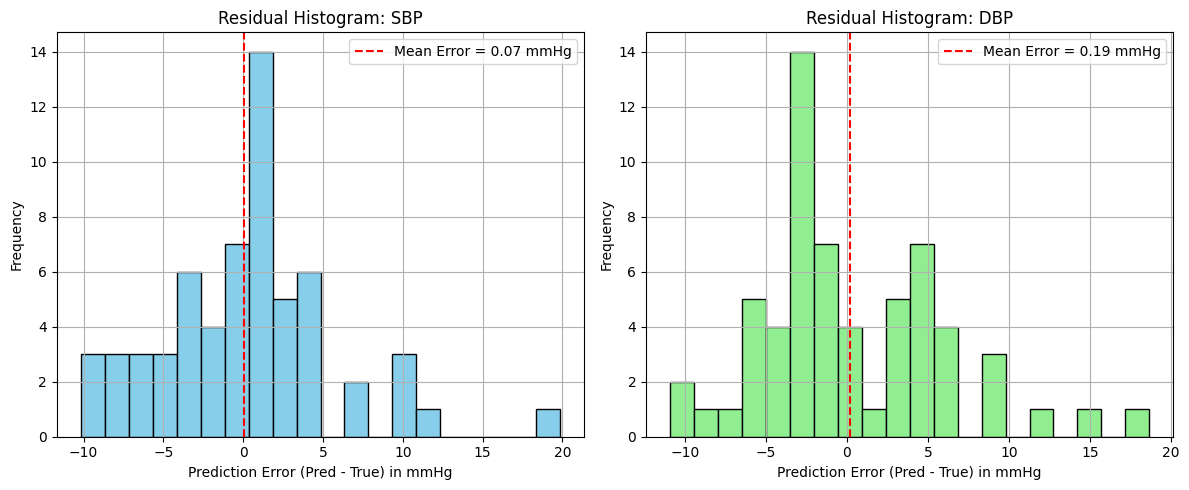

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate residuals (prediction error)
sbp_errors = sbp_pred - sbp_true
dbp_errors = dbp_pred - dbp_true

# Plot Histogram of Errors
plt.figure(figsize=(12, 5))

# --- SBP ---
plt.subplot(1, 2, 1)
plt.hist(sbp_errors, bins=20, color='skyblue', edgecolor='black')
plt.axvline(np.mean(sbp_errors), color='red', linestyle='--', label=f'Mean Error = {np.mean(sbp_errors):.2f} mmHg')
plt.title("Residual Histogram: SBP")
plt.xlabel("Prediction Error (Pred - True) in mmHg")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()

# --- DBP ---
plt.subplot(1, 2, 2)
plt.hist(dbp_errors, bins=20, color='lightgreen', edgecolor='black')
plt.axvline(np.mean(dbp_errors), color='red', linestyle='--', label=f'Mean Error = {np.mean(dbp_errors):.2f} mmHg')
plt.title("Residual Histogram: DBP")
plt.xlabel("Prediction Error (Pred - True) in mmHg")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [32]:
import numpy as np

# Compute absolute errors
sbp_error = np.abs(sbp_pred - sbp_true)
dbp_error = np.abs(dbp_pred - dbp_true)

# Define thresholds
thresholds = [5, 10, 15]

print("\n📈 Accuracy at Error Thresholds:")

for t in thresholds:
    sbp_pct = np.mean(sbp_error <= t) * 100
    dbp_pct = np.mean(dbp_error <= t) * 100
    print(f"SBP within ±{t} mmHg: {sbp_pct:.2f}%")
    print(f"DBP within ±{t} mmHg: {dbp_pct:.2f}%")



📈 Accuracy at Error Thresholds:
SBP within ±5 mmHg: 70.49%
DBP within ±5 mmHg: 67.21%
SBP within ±10 mmHg: 93.44%
DBP within ±10 mmHg: 93.44%
SBP within ±15 mmHg: 98.36%
DBP within ±15 mmHg: 98.36%


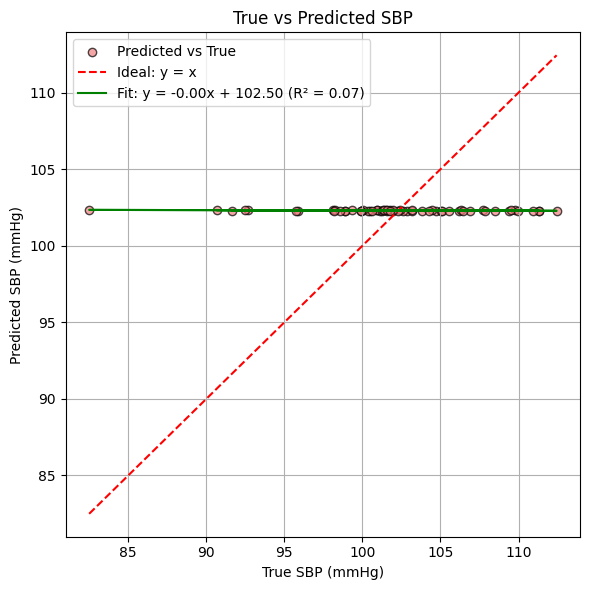

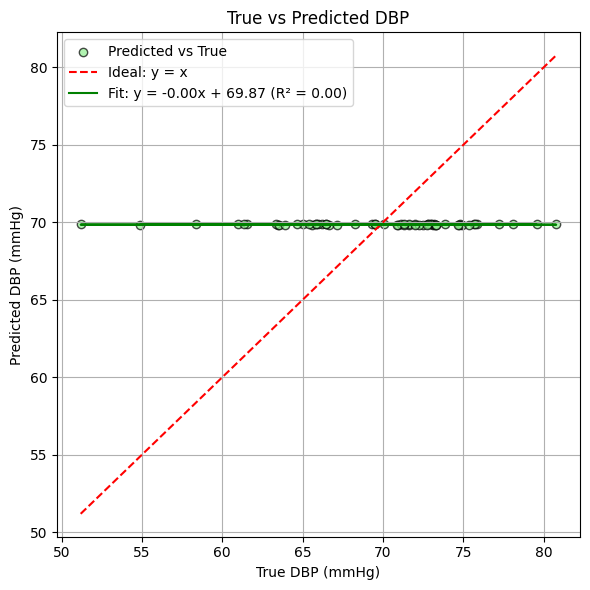

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

def plot_true_vs_pred(true, pred, label="SBP", color='skyblue'):
    # Reshape for sklearn
    true_reshaped = true.reshape(-1, 1)

    # Fit regression line
    model = LinearRegression().fit(true_reshaped, pred)
    pred_line = model.predict(true_reshaped)
    slope = model.coef_[0]
    intercept = model.intercept_
    r2 = model.score(true_reshaped, pred)

    # Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(true, pred, alpha=0.7, label='Predicted vs True', color=color, edgecolor='k')
    plt.plot([true.min(), true.max()], [true.min(), true.max()], 'r--', label='Ideal: y = x')
    plt.plot(true, pred_line, 'g-', label=f'Fit: y = {slope:.2f}x + {intercept:.2f} (R² = {r2:.2f})')

    # Labels
    plt.xlabel(f'True {label} (mmHg)')
    plt.ylabel(f'Predicted {label} (mmHg)')
    plt.title(f'True vs Predicted {label}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ✅ Call for SBP and DBP
plot_true_vs_pred(sbp_true, sbp_pred, label="SBP", color='lightcoral')
plot_true_vs_pred(dbp_true, dbp_pred, label="DBP", color='lightgreen')


In [34]:
print("SBP prediction std:", np.std(sbp_pred))
print("DBP prediction std:", np.std(dbp_pred))


SBP prediction std: 0.039574545
DBP prediction std: 0.019185713


In [35]:
print("LSTM final FC bias:", model.fc.bias.data)


LSTM final FC bias: tensor([-0.0058,  0.0015])


In [36]:
train_preds = model(X_train).detach().numpy()
train_preds_inv = target_scaler.inverse_transform(train_preds)
print("Train SBP mean ± std:", np.mean(train_preds_inv[:, 0]), np.std(train_preds_inv[:, 0]))


Train SBP mean ± std: 102.30789 0.04069442


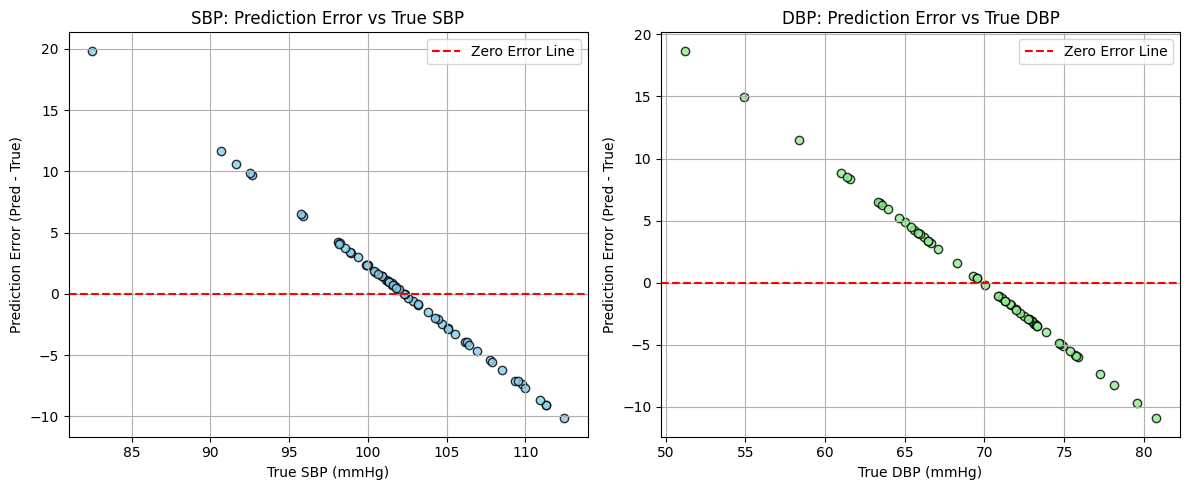

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# --- Compute Errors ---
sbp_error = sbp_pred - sbp_true
dbp_error = dbp_pred - dbp_true

# --- Plot ---
plt.figure(figsize=(12, 5))

# 1️⃣ SBP Plot
plt.subplot(1, 2, 1)
plt.scatter(sbp_true, sbp_error, color='skyblue', edgecolor='k', alpha=0.8)
plt.axhline(0, color='red', linestyle='--', linewidth=1.5, label='Zero Error Line')
plt.title('SBP: Prediction Error vs True SBP')
plt.xlabel('True SBP (mmHg)')
plt.ylabel('Prediction Error (Pred - True)')
plt.grid(True)
plt.legend()

# 2️⃣ DBP Plot
plt.subplot(1, 2, 2)
plt.scatter(dbp_true, dbp_error, color='lightgreen', edgecolor='k', alpha=0.8)
plt.axhline(0, color='red', linestyle='--', linewidth=1.5, label='Zero Error Line')
plt.title('DBP: Prediction Error vs True DBP')
plt.xlabel('True DBP (mmHg)')
plt.ylabel('Prediction Error (Pred - True)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [38]:
from scipy.stats import pearsonr

sbp_corr, _ = pearsonr(sbp_true, sbp_pred - sbp_true)
dbp_corr, _ = pearsonr(dbp_true, dbp_pred - dbp_true)

print(f"SBP Error Correlation: {sbp_corr:.2f}")
print(f"DBP Error Correlation: {dbp_corr:.2f}")


SBP Error Correlation: -1.00
DBP Error Correlation: -1.00


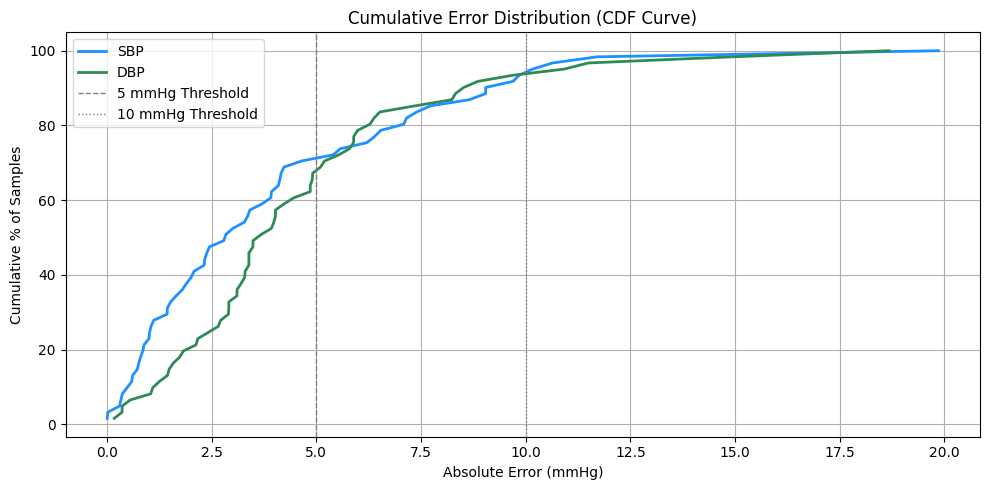

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Compute absolute errors
sbp_abs_error = np.abs(sbp_pred - sbp_true)
dbp_abs_error = np.abs(dbp_pred - dbp_true)

# Sort errors
sbp_sorted = np.sort(sbp_abs_error)
dbp_sorted = np.sort(dbp_abs_error)

# Cumulative percentage
sbp_cdf = np.arange(1, len(sbp_sorted) + 1) / len(sbp_sorted) * 100
dbp_cdf = np.arange(1, len(dbp_sorted) + 1) / len(dbp_sorted) * 100

# Plot
plt.figure(figsize=(10, 5))

plt.plot(sbp_sorted, sbp_cdf, label='SBP', color='dodgerblue', lw=2)
plt.plot(dbp_sorted, dbp_cdf, label='DBP', color='seagreen', lw=2)

plt.axvline(5, color='gray', linestyle='--', lw=1, label='5 mmHg Threshold')
plt.axvline(10, color='gray', linestyle=':', lw=1, label='10 mmHg Threshold')

plt.xlabel('Absolute Error (mmHg)')
plt.ylabel('Cumulative % of Samples')
plt.title('Cumulative Error Distribution (CDF Curve)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [40]:
within_5_sbp = np.mean(sbp_abs_error <= 5) * 100
within_5_dbp = np.mean(dbp_abs_error <= 5) * 100

within_10_sbp = np.mean(sbp_abs_error <= 10) * 100
within_10_dbp = np.mean(dbp_abs_error <= 10) * 100

print(f"SBP within 5 mmHg:  {within_5_sbp:.1f}%")
print(f"DBP within 5 mmHg:  {within_5_dbp:.1f}%")
print(f"SBP within 10 mmHg: {within_10_sbp:.1f}%")
print(f"DBP within 10 mmHg: {within_10_dbp:.1f}%")


SBP within 5 mmHg:  70.5%
DBP within 5 mmHg:  67.2%
SBP within 10 mmHg: 93.4%
DBP within 10 mmHg: 93.4%


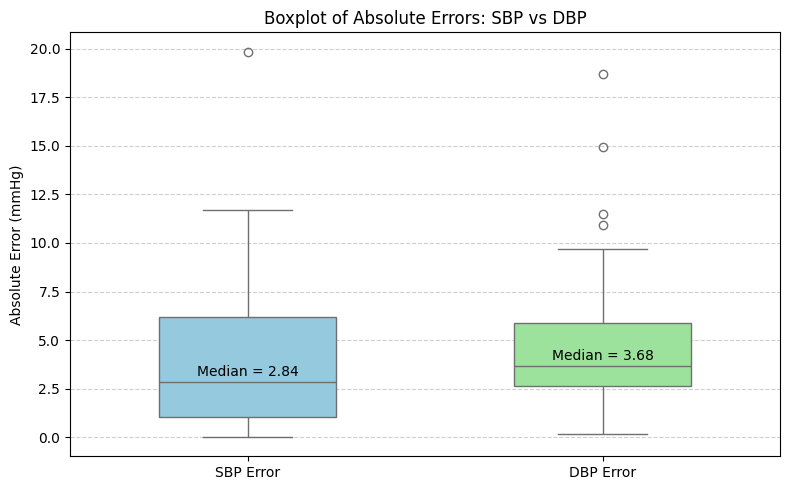

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1️⃣ Calculate absolute errors
sbp_abs_error = np.abs(sbp_pred - sbp_true)
dbp_abs_error = np.abs(dbp_pred - dbp_true)

# 2️⃣ Create boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(data=[sbp_abs_error, dbp_abs_error], palette=['skyblue', 'lightgreen'], width=0.5)

# 3️⃣ Add settings
plt.xticks([0, 1], ['SBP Error', 'DBP Error'])
plt.ylabel("Absolute Error (mmHg)")
plt.title("Boxplot of Absolute Errors: SBP vs DBP")
plt.grid(axis='y', linestyle='--', alpha=0.6)

# 4️⃣ Annotate median values
for i, errors in enumerate([sbp_abs_error, dbp_abs_error]):
    median_val = np.median(errors)
    plt.text(i, median_val + 0.3, f'Median = {median_val:.2f}', ha='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()


In [43]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
import numpy as np

# Already available:
# sbp_pred, sbp_true, dbp_pred, dbp_true

# Utility: Lin's CCC
def lins_ccc(y_true, y_pred):
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    cov = np.mean((y_true - mean_true) * (y_pred - mean_pred))

    return (2 * cov) / (var_true + var_pred + (mean_true - mean_pred) ** 2 + 1e-8)

# Utility: % within ±5 mmHg
def within_range_percentage(y_true, y_pred, threshold=5):
    abs_error = np.abs(y_pred - y_true)
    return np.sum(abs_error <= threshold) / len(y_true) * 100

# Utility: Full metric set
def compute_metrics(y_true, y_pred, label="SBP"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    bias = np.mean(y_pred - y_true)
    std = np.std(y_pred - y_true)
    pct_5mmHg = within_range_percentage(y_true, y_pred, threshold=5)
    ccc = lins_ccc(y_true, y_pred)

    print(f"\n📊 {label} Metrics Summary:")
    print(f"✅ MAE  = {mae:.2f} mmHg")
    print(f"✅ RMSE = {rmse:.2f} mmHg")
    print(f"✅ Bias (Mean Error) = {bias:.2f} mmHg")
    print(f"✅ SD of Error       = {std:.2f} mmHg")
    print(f"✅ % within ±5 mmHg  = {pct_5mmHg:.2f}%")
    print(f"✅ Lin’s CCC         = {ccc:.4f}")

# Call for both SBP and DBP
compute_metrics(sbp_true, sbp_pred, label="SBP")
compute_metrics(dbp_true, dbp_pred, label="DBP")



📊 SBP Metrics Summary:
✅ MAE  = 4.00 mmHg
✅ RMSE = 5.47 mmHg
✅ Bias (Mean Error) = 0.07 mmHg
✅ SD of Error       = 5.47 mmHg
✅ % within ±5 mmHg  = 70.49%
✅ Lin’s CCC         = -0.0039

📊 DBP Metrics Summary:
✅ MAE  = 4.60 mmHg
✅ RMSE = 5.72 mmHg
✅ Bias (Mean Error) = 0.19 mmHg
✅ SD of Error       = 5.72 mmHg
✅ % within ±5 mmHg  = 67.21%
✅ Lin’s CCC         = -0.0004


In [44]:
import numpy as np

def pseudo_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

# Example usage:
sbp_pseudo_r2 = pseudo_r2(sbp_true, sbp_pred)
dbp_pseudo_r2 = pseudo_r2(dbp_true, dbp_pred)

print(f"📈 SBP Pseudo R²: {sbp_pseudo_r2:.4f}")
print(f"📈 DBP Pseudo R²: {dbp_pseudo_r2:.4f}")


📈 SBP Pseudo R²: -0.0041
📈 DBP Pseudo R²: -0.0014


In [29]:
pip install bioread

Note: you may need to restart the kernel to use updated packages.


Sampling Rate: 500.0 Hz
Number of channels: 3

Channel 1:
  Name     : ECG (.05 - 100 Hz, AHA) 
  Units    : mV
  Samples  : 268289

Channel 2:
  Name     : Respiration
  Units    : mV
  Samples  : 268289

Channel 3:
  Name     : PPG (Pulse)
  Units    : mV
  Samples  : 268289



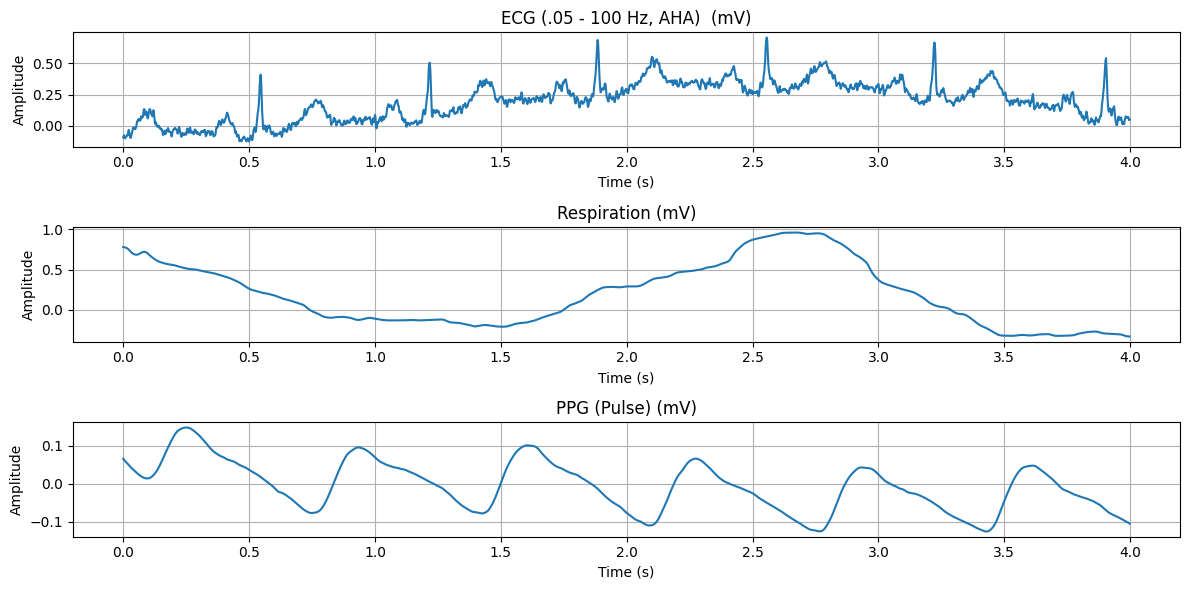

In [30]:
import bioread
import matplotlib.pyplot as plt

# === Load the .acq file ===
file_path = "C:/ML Projects/FINAL_TRY_UCI_DATASET_LASSO/Sub1.acq"  # Change this to your actual file path
data = bioread.read_file(file_path)

# === Print basic info ===
print(f"Sampling Rate: {data.channels[0].samples_per_second} Hz")
print(f"Number of channels: {len(data.channels)}\n")

for i, channel in enumerate(data.channels):
    print(f"Channel {i+1}:")
    print(f"  Name     : {channel.name}")
    print(f"  Units    : {channel.units}")
    print(f"  Samples  : {len(channel.data)}")
    print()

# === Plot first few seconds of each channel ===
plt.figure(figsize=(12, 6))
for i, channel in enumerate(data.channels):
    t = channel.time_index  # Time in seconds
    y = channel.data
    plt.subplot(len(data.channels), 1, i+1)
    plt.plot(t[:2000], y[:2000])
    plt.title(f"{channel.name} ({channel.units})")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)

plt.tight_layout()
plt.show()


In [31]:
import os
import pandas as pd
import numpy as np
import bioread  # pip install bioread

# Paths
acq_folder = "D:/OIP_IIIT_Naya_Raipur_Internship/PENDRIVE_DATASET/DataSet/acq_data_master"
metadata_csv = "D:/OIP_IIIT_Naya_Raipur_Internship/PENDRIVE_DATASET/DataSet/Mater_Dataset_SBP_DBP.csv"

# Step 1: Load metadata CSV
metadata = pd.read_csv(metadata_csv)
metadata['Name'] = metadata['Name'].astype(str).str.strip()

# Step 2: Parse all acq files and extract PPG (Channel 3)
ppg_data = {}  # key: Subject_ID, value: PPG numpy array

for file in os.listdir(acq_folder):
    if file.endswith(".acq"):
        subject_id = os.path.splitext(file)[0]  # e.g., 'Sub1'
        filepath = os.path.join(acq_folder, file)
        
        try:
            acq = bioread.read_file(filepath)
            ppg_channel = acq.channels[-1]  # Channel 3 = PPG
            ppg_signal = np.array(ppg_channel.data)

            # Sanity check: ensure subject exists in metadata
            if subject_id in metadata['Name'].values:
                ppg_data[subject_id] = ppg_signal
            else:
                print(f"⚠️ Warning: {subject_id} not found in metadata CSV")

        except Exception as e:
            print(f"❌ Error reading {file}: {e}")


print(f"\n✅ Loaded PPG signals for {len(ppg_data)} subjects.")



✅ Loaded PPG signals for 46 subjects.


In [32]:
import os
import pandas as pd
import numpy as np
import bioread  # pip install bioread

# Paths
acq_folder = "D:/OIP_IIIT_Naya_Raipur_Internship/PENDRIVE_DATASET/DataSet/acq_data_master"
metadata_csv = "D:/OIP_IIIT_Naya_Raipur_Internship/PENDRIVE_DATASET/DataSet/Mater_Dataset_SBP_DBP.csv"

# Step 1: Load CSV metadata
metadata = pd.read_csv(metadata_csv)
metadata['Name'] = metadata['Name'].astype(str).str.strip()

# Step 2: Extract PPG signal (channel 3) from each .acq file
ppg_subject_data = {}  # key = 'Sub1', value = (ppg_array, SBP, DBP)

for file in os.listdir(acq_folder):
    if file.endswith(".acq"):
        subject_id = os.path.splitext(file)[0].strip()  # e.g., 'Sub1'
        file_path = os.path.join(acq_folder, file)

        if subject_id in metadata['Name'].values:
            try:
                acq = bioread.read_file(file_path)
                ppg_signal = np.array(acq.channels[-1].data)  # Last channel = PPG

                # Get SBP and DBP from CSV
                row = metadata[metadata['Name'] == subject_id]
                sbp = float(row['Systolic BP'].values[0])
                dbp = float(row['Diastolic BP'].values[0])

                ppg_subject_data[subject_id] = (ppg_signal, sbp, dbp)

            except Exception as e:
                print(f"❌ Error reading {file}: {e}")
        else:
            print(f"⚠️ {subject_id} not found in metadata")

print(f"\n✅ Loaded {len(ppg_subject_data)} subjects with PPG + SBP/DBP data.")



✅ Loaded 46 subjects with PPG + SBP/DBP data.


In [33]:
for subject_id, ppg_signal in ppg_data.items():
    sbp = metadata.loc[metadata['Name'] == subject_id, 'Systolic BP'].values[0]
    dbp = metadata.loc[metadata['Name'] == subject_id, 'Diastolic BP'].values[0]
    
    # Step 2 (below): process `ppg_signal` like in main pipeline


In [34]:
segment_length = 1250  # 10 seconds
overlap = 0.5  # 50% overlap
step_size = int(segment_length * (1 - overlap))  # e.g., 625 samples


In [35]:
ppg_segments = []  # each entry: (subject_id, segment_index, segment_array)

for subject_id, ppg_signal in ppg_data.items():
    num_segments = (len(ppg_signal) - segment_length) // step_size + 1
    
    for i in range(num_segments):
        start = i * step_size
        end = start + segment_length
        segment = ppg_signal[start:end]
        ppg_segments.append((subject_id, i, segment))


In [36]:
ppg_labeled = []  # each entry: (subject_id, segment_idx, segment, sbp, dbp)

for subject_id, segment_idx, segment in ppg_segments:
    row = metadata[metadata['Name'] == subject_id]
    if not row.empty:
        sbp = row['Systolic BP'].values[0]
        dbp = row['Diastolic BP'].values[0]

        if not np.isnan(sbp) and not np.isnan(dbp):
            ppg_labeled.append((subject_id, segment_idx, segment, sbp, dbp))
        else:
            print(f"⚠️ Missing SBP/DBP for {subject_id}")

print(f"\n✅ Final labeled segments: {len(ppg_labeled)}")



✅ Final labeled segments: 14358


In [37]:
print("Subjects in acq files but not in CSV:", set(ppg_data.keys()) - set(metadata['Name'].values))
print("Subjects in CSV but no acq file:", set(metadata['Name'].values) - set(ppg_data.keys()))


Subjects in acq files but not in CSV: set()
Subjects in CSV but no acq file: set()


In [38]:
import numpy as np
from scipy.signal import savgol_filter

# === Step 4: Detrending using 5th-degree polynomial (SPA-style) ===
def detrend_spa(signal, poly_order=5):
    x = np.arange(len(signal))
    coeffs = np.polyfit(x, signal, deg=poly_order)
    trend = np.polyval(coeffs, x)
    return signal - trend

# === Step 5: SNR Computation ===
def compute_snr(signal, noise_estimate):
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise_estimate ** 2)
    snr = 10 * np.log10(signal_power / (noise_power + 1e-8))  # Avoid division by zero
    return snr

# === Process All Segments ===
detrended_segments = []
valid_segments = []

for subject_id, seg_idx, raw_segment, sbp, dbp in ppg_labeled:
    detrended = detrend_spa(raw_segment)
    smoothed = savgol_filter(detrended, window_length=51, polyorder=3)
    residual_noise = detrended - smoothed

    snr = compute_snr(detrended, residual_noise)

    if snr >= 3.0:
        detrended_segments.append((subject_id, seg_idx, detrended))
        valid_segments.append((subject_id, seg_idx))

        print(f"✅ Kept: {subject_id}, Segment {seg_idx}, SNR = {snr:.2f} dB")
    else:
        print(f"❌ Discarded: {subject_id}, Segment {seg_idx}, SNR = {snr:.2f} dB")

print(f"\n✅ Final valid detrended segments: {len(detrended_segments)}")


✅ Kept: Sub1, Segment 0, SNR = 39.36 dB
✅ Kept: Sub1, Segment 1, SNR = 38.64 dB
✅ Kept: Sub1, Segment 2, SNR = 38.96 dB
✅ Kept: Sub1, Segment 3, SNR = 37.80 dB
✅ Kept: Sub1, Segment 4, SNR = 35.50 dB
✅ Kept: Sub1, Segment 5, SNR = 35.69 dB
✅ Kept: Sub1, Segment 6, SNR = 36.31 dB
✅ Kept: Sub1, Segment 7, SNR = 36.24 dB
✅ Kept: Sub1, Segment 8, SNR = 36.17 dB
✅ Kept: Sub1, Segment 9, SNR = 35.06 dB
✅ Kept: Sub1, Segment 10, SNR = 33.86 dB
✅ Kept: Sub1, Segment 11, SNR = 35.34 dB
✅ Kept: Sub1, Segment 12, SNR = 34.22 dB
✅ Kept: Sub1, Segment 13, SNR = 32.42 dB
✅ Kept: Sub1, Segment 14, SNR = 31.22 dB
✅ Kept: Sub1, Segment 15, SNR = 27.29 dB
✅ Kept: Sub1, Segment 16, SNR = 28.67 dB
✅ Kept: Sub1, Segment 17, SNR = 29.50 dB
✅ Kept: Sub1, Segment 18, SNR = 30.36 dB
✅ Kept: Sub1, Segment 19, SNR = 30.12 dB
✅ Kept: Sub1, Segment 20, SNR = 29.85 dB
✅ Kept: Sub1, Segment 21, SNR = 27.34 dB
✅ Kept: Sub1, Segment 22, SNR = 28.88 dB
✅ Kept: Sub1, Segment 23, SNR = 25.14 dB
✅ Kept: Sub1, Segment 24, 

In [39]:
# Check one-to-one correspondence
all_keys_detrended = {(sid, idx) for (sid, idx, _) in detrended_segments}
all_keys_cycle = {(sid, idx) for (sid, idx, _, _) in cycle_data}

unmatched = all_keys_cycle - all_keys_detrended
print(f"Total unmatched (missing) = {len(unmatched)} out of {len(all_keys_cycle)}")


Total unmatched (missing) = 7 out of 7


In [40]:
print("📦 Keys in detrended_segments:")
for sid, idx, _ in detrended_segments:
    print(f" -> ({repr(sid)}, {idx})")

print("\n📦 Keys in cycle_data:")
for sid, idx, _, _ in cycle_data:
    print(f" -> ({repr(sid)}, {idx})")


📦 Keys in detrended_segments:
 -> ('Sub1', 0)
 -> ('Sub1', 1)
 -> ('Sub1', 2)
 -> ('Sub1', 3)
 -> ('Sub1', 4)
 -> ('Sub1', 5)
 -> ('Sub1', 6)
 -> ('Sub1', 7)
 -> ('Sub1', 8)
 -> ('Sub1', 9)
 -> ('Sub1', 10)
 -> ('Sub1', 11)
 -> ('Sub1', 12)
 -> ('Sub1', 13)
 -> ('Sub1', 14)
 -> ('Sub1', 15)
 -> ('Sub1', 16)
 -> ('Sub1', 17)
 -> ('Sub1', 18)
 -> ('Sub1', 19)
 -> ('Sub1', 20)
 -> ('Sub1', 21)
 -> ('Sub1', 22)
 -> ('Sub1', 23)
 -> ('Sub1', 24)
 -> ('Sub1', 25)
 -> ('Sub1', 26)
 -> ('Sub1', 27)
 -> ('Sub1', 28)
 -> ('Sub1', 29)
 -> ('Sub1', 30)
 -> ('Sub1', 31)
 -> ('Sub1', 32)
 -> ('Sub1', 33)
 -> ('Sub1', 34)
 -> ('Sub1', 35)
 -> ('Sub1', 36)
 -> ('Sub1', 37)
 -> ('Sub1', 38)
 -> ('Sub1', 39)
 -> ('Sub1', 40)
 -> ('Sub1', 41)
 -> ('Sub1', 42)
 -> ('Sub1', 43)
 -> ('Sub1', 44)
 -> ('Sub1', 45)
 -> ('Sub1', 46)
 -> ('Sub1', 47)
 -> ('Sub1', 48)
 -> ('Sub1', 49)
 -> ('Sub1', 50)
 -> ('Sub1', 51)
 -> ('Sub1', 52)
 -> ('Sub1', 53)
 -> ('Sub1', 54)
 -> ('Sub1', 55)
 -> ('Sub1', 56)
 -> ('Sub1'

In [41]:
'''
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import welch
from scipy.integrate import trapezoid

fs = 500  # Sampling frequency
all_features = []
missing_count = 0
valid_cycles = 0

for subject_id, seg_idx, peaks, valleys in cycle_data:
    matches = [seg for (sid, idx, seg) in detrended_segments if sid == subject_id and idx == seg_idx]
    if not matches:
        missing_count += 1
        continue

    detrended_ppg = matches[0]

    for j in range(len(peaks) - 1):
        start = peaks[j]
        end = peaks[j + 1]
        cycle = detrended_ppg[start:end]

        if len(cycle) < 20:
            continue

        valid_cycles += 1

        # Morphological Features
        mean_val = np.mean(cycle)
        sd_val = np.std(cycle)
        kurt = kurtosis(cycle)
        skew_val = skew(cycle)
        peak_val = np.max(cycle)
        valley_val = np.min(cycle)
        K = (mean_val - valley_val) / (peak_val - valley_val + 1e-8)
        morph_features = [sd_val, kurt, skew_val, K]

        # PWx, SWx, DWx, PWRx at 7 percentages
        PW, SW, DW, PWR = [], [], [], []
        for perc in [0.90, 0.75, 0.66, 0.50, 0.33, 0.25, 0.10]:
            height = valley_val + perc * (peak_val - valley_val)
            above = np.where(cycle >= height)[0]
            if len(above) > 1:
                width = (above[-1] - above[0]) / fs
                systolic = (np.argmax(cycle) - above[0]) / fs
                diastolic = (above[-1] - np.argmax(cycle)) / fs
                PW.append(width)
                SW.append(systolic)
                DW.append(diastolic)
                PWR.append(systolic / (diastolic + 1e-8))
            else:
                PW.append(0)
                SW.append(0)
                DW.append(0)
                PWR.append(0)

        # Gradient-based features
        dt = 1 / fs
        p = cycle
        m = np.argmax(p)
        L = len(p)

        AS = [(p[t+1] - p[t]) / dt for t in range(0, m)] if m > 1 else []
        ASmax = max(AS) if AS else 0
        ASmean = np.mean(AS) if AS else 0

        DS = [(p[t+1] - p[t]) / dt for t in range(m+1, L-1)] if L - m > 2 else []
        DSmax = max(DS) if DS else 0
        DSmean = np.mean(DS) if DS else 0

        AA = [(p[t+2] - 2*p[t+1] + p[t]) / dt for t in range(0, m-2)] if m > 3 else []
        AAmax = max(AA) if AA else 0
        AAmean = np.mean(AA) if AA else 0

        DA = [(p[t+2] - 2*p[t+1] + p[t]) / dt for t in range(m+1, L-2)] if L - m > 3 else []
        DAmax = max(DA) if DA else 0
        DAmean = np.mean(DA) if DA else 0

        gradient_features = [ASmax, ASmean, DSmax, DSmean, AAmax, AAmean, DAmax, DAmean]

        # Time + Amplitude Features
        CL = len(cycle) / fs
        ST = (m - 0) / fs
        DT = (len(cycle) - m) / fs
        DT_ST_ratio = DT / (ST + 1e-8)

        AC = peak_val - valley_val
        DC = mean_val
        mNPV = AC / (AC + DC + 1e-8)

        SArea = trapezoid(cycle[:m], dx=1/fs)
        DArea = trapezoid(cycle[m:], dx=1/fs)
        RI = DArea / (SArea + 1e-8)

        time_amp_features = [CL, ST, DT, DT_ST_ratio, AC, DC, mNPV, SArea, DArea, RI]

        # HRV Features (basic RR)
        rr_intervals = np.diff(peaks) / fs
        if len(rr_intervals) >= 2:
            diff_rr = np.diff(rr_intervals)
            RMSSD = np.sqrt(np.mean(diff_rr**2))
            SDSD = np.std(diff_rr)
            SDNN = np.std(rr_intervals)

            f, pxx = welch(rr_intervals, fs=4.0, nperseg=min(256, len(rr_intervals)))
            lf_band = (f >= 0.04) & (f <= 0.15)
            hf_band = (f > 0.15) & (f <= 0.4)
            LF = trapezoid(pxx[lf_band], f[lf_band]) if np.any(lf_band) else 0
            HF = trapezoid(pxx[hf_band], f[hf_band]) if np.any(hf_band) else 0
            LF_HF = LF / (HF + 1e-8)
        else:
            RMSSD, SDSD, SDNN, LF_HF = 0, 0, 0, 0

        hrv_features = [RMSSD, SDSD, SDNN, LF_HF]

        # Combine all 54 features
        full_vector = morph_features + PW + SW + DW + PWR + gradient_features + time_amp_features + hrv_features
        all_features.append(full_vector)

# Convert and check
X_aims = np.array(all_features)

# Safe print
if X_aims.ndim == 2:
    print(f"\n✅ Extracted {X_aims.shape[0]} cycles with {X_aims.shape[1]} features each.")
else:
    print("❌ No valid features extracted. Check previous steps!")

print(f"⚠️ Skipped {missing_count} segments due to missing detrended PPG.")
print(f"✅ Total valid cycles used: {valid_cycles}") '''


'\nimport numpy as np\nfrom scipy.stats import skew, kurtosis\nfrom scipy.signal import welch\nfrom scipy.integrate import trapezoid\n\nfs = 500  # Sampling frequency\nall_features = []\nmissing_count = 0\nvalid_cycles = 0\n\nfor subject_id, seg_idx, peaks, valleys in cycle_data:\n    matches = [seg for (sid, idx, seg) in detrended_segments if sid == subject_id and idx == seg_idx]\n    if not matches:\n        missing_count += 1\n        continue\n\n    detrended_ppg = matches[0]\n\n    for j in range(len(peaks) - 1):\n        start = peaks[j]\n        end = peaks[j + 1]\n        cycle = detrended_ppg[start:end]\n\n        if len(cycle) < 20:\n            continue\n\n        valid_cycles += 1\n\n        # Morphological Features\n        mean_val = np.mean(cycle)\n        sd_val = np.std(cycle)\n        kurt = kurtosis(cycle)\n        skew_val = skew(cycle)\n        peak_val = np.max(cycle)\n        valley_val = np.min(cycle)\n        K = (mean_val - valley_val) / (peak_val - valley_val

In [42]:
import os
import numpy as np
import pandas as pd
import bioread
from scipy.signal import savgol_filter, find_peaks, welch
from scipy.stats import skew, kurtosis
from scipy.integrate import trapezoid

# === CONFIGURATION ===
fs = 500  # Sampling rate
segment_length = 1250  # 10 seconds
overlap = 0.5
step_size = int(segment_length * (1 - overlap))

# === PATHS ===
acq_folder = "D:/OIP_IIIT_Naya_Raipur_Internship/PENDRIVE_DATASET/DataSet/acq_data_master"
metadata_csv = "D:/OIP_IIIT_Naya_Raipur_Internship/PENDRIVE_DATASET/DataSet/Mater_Dataset_SBP_DBP.csv"

# === STEP 1: Load Metadata ===
metadata = pd.read_csv(metadata_csv)
metadata['Name'] = metadata['Name'].astype(str).str.strip()

# === STEP 2: Extract PPG Data ===
ppg_subject_data = {}
for file in os.listdir(acq_folder):
    if file.endswith(".acq"):
        subject_id = os.path.splitext(file)[0].strip()
        file_path = os.path.join(acq_folder, file)

        if subject_id in metadata['Name'].values:
            try:
                acq = bioread.read_file(file_path)
                ppg_signal = np.array(acq.channels[-1].data)
                row = metadata[metadata['Name'] == subject_id]
                sbp = float(row['Systolic BP'].values[0])
                dbp = float(row['Diastolic BP'].values[0])
                ppg_subject_data[subject_id] = (ppg_signal, sbp, dbp)
            except Exception as e:
                print(f"❌ Error reading {file}: {e}")

# === STEP 3: Segmenting ===
ppg_labeled = []
for subject_id, (ppg_signal, sbp, dbp) in ppg_subject_data.items():
    num_segments = (len(ppg_signal) - segment_length) // step_size + 1
    for i in range(num_segments):
        start = i * step_size
        end = start + segment_length
        segment = ppg_signal[start:end]
        ppg_labeled.append((subject_id, i, segment, sbp, dbp))

# === STEP 4: Detrending & SNR Filtering ===
def detrend_spa(signal, poly_order=5):
    x = np.arange(len(signal))
    coeffs = np.polyfit(x, signal, deg=poly_order)
    trend = np.polyval(coeffs, x)
    return signal - trend

def compute_snr(signal, noise):
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    return 10 * np.log10(signal_power / (noise_power + 1e-8))

detrended_segments = []
for subject_id, seg_idx, raw_segment, sbp, dbp in ppg_labeled:
    detrended = detrend_spa(raw_segment)
    smoothed = savgol_filter(detrended, window_length=51, polyorder=3)
    residual_noise = detrended - smoothed
    snr = compute_snr(detrended, residual_noise)
    if snr >= 3.0:
        detrended_segments.append((subject_id, seg_idx, detrended))

# === STEP 5: Cycle Detection ===
min_interval = int(fs / 4.0)
max_interval = int(fs / 0.8)
cycle_data = []
for subject_id, seg_idx, detrended_ppg in detrended_segments:
    peak_thresh = 0.5 * np.max(detrended_ppg)
    valley_thresh = 0.5 * np.min(detrended_ppg)
    peak_indices, _ = find_peaks(detrended_ppg, height=peak_thresh, distance=min_interval)
    valley_indices, _ = find_peaks(-detrended_ppg, height=-valley_thresh, distance=min_interval)

    valid_peaks = [peak_indices[i-1] for i in range(1, len(peak_indices))
                   if min_interval <= (peak_indices[i] - peak_indices[i-1]) <= max_interval]
    if len(peak_indices) > 0:
        valid_peaks.append(peak_indices[-1])

    valid_valleys = [valley_indices[i-1] for i in range(1, len(valley_indices))
                     if min_interval <= (valley_indices[i] - valley_indices[i-1]) <= max_interval]
    if len(valley_indices) > 0:
        valid_valleys.append(valley_indices[-1])

    if len(valid_peaks) > 2:
        cycle_data.append((subject_id, seg_idx, valid_peaks, valid_valleys))

# === STEP 6: Feature Extraction ===
all_features = []
valid_cycles = 0
missing_count = 0
for subject_id, seg_idx, peaks, valleys in cycle_data:
    matches = [seg for (sid, idx, seg) in detrended_segments if sid == subject_id and idx == seg_idx]
    if not matches:
        missing_count += 1
        continue
    detrended_ppg = matches[0]

    for j in range(len(peaks) - 1):
        start = peaks[j]
        end = peaks[j + 1]
        cycle = detrended_ppg[start:end]
        if len(cycle) < 20:
            continue
        valid_cycles += 1
        mean_val = np.mean(cycle)
        sd_val = np.std(cycle)
        kurt = kurtosis(cycle)
        skew_val = skew(cycle)
        peak_val = np.max(cycle)
        valley_val = np.min(cycle)
        K = (mean_val - valley_val) / (peak_val - valley_val + 1e-8)
        morph_features = [sd_val, kurt, skew_val, K]

        PW, SW, DW, PWR = [], [], [], []
        for perc in [0.90, 0.75, 0.66, 0.50, 0.33, 0.25, 0.10]:
            height = valley_val + perc * (peak_val - valley_val)
            above = np.where(cycle >= height)[0]
            if len(above) > 1:
                width = (above[-1] - above[0]) / fs
                systolic = (np.argmax(cycle) - above[0]) / fs
                diastolic = (above[-1] - np.argmax(cycle)) / fs
                PW.append(width)
                SW.append(systolic)
                DW.append(diastolic)
                PWR.append(systolic / (diastolic + 1e-8))
            else:
                PW += [0]; SW += [0]; DW += [0]; PWR += [0]

        dt = 1 / fs
        p = cycle
        m = np.argmax(p)
        L = len(p)
        AS = [(p[t+1] - p[t]) / dt for t in range(0, m)] if m > 1 else []
        ASmax = max(AS) if AS else 0
        ASmean = np.mean(AS) if AS else 0
        DS = [(p[t+1] - p[t]) / dt for t in range(m+1, L-1)] if L - m > 2 else []
        DSmax = max(DS) if DS else 0
        DSmean = np.mean(DS) if DS else 0
        AA = [(p[t+2] - 2*p[t+1] + p[t]) / dt for t in range(0, m-2)] if m > 3 else []
        AAmax = max(AA) if AA else 0
        AAmean = np.mean(AA) if AA else 0
        DA = [(p[t+2] - 2*p[t+1] + p[t]) / dt for t in range(m+1, L-2)] if L - m > 3 else []
        DAmax = max(DA) if DA else 0
        DAmean = np.mean(DA) if DA else 0
        gradient_features = [ASmax, ASmean, DSmax, DSmean, AAmax, AAmean, DAmax, DAmean]

        CL = len(cycle) / fs
        ST = (m - 0) / fs
        DT = (len(cycle) - m) / fs
        DT_ST_ratio = DT / (ST + 1e-8)
        AC = peak_val - valley_val
        DC = mean_val
        mNPV = AC / (AC + DC + 1e-8)
        SArea = trapezoid(cycle[:m], dx=1/fs)
        DArea = trapezoid(cycle[m:], dx=1/fs)
        RI = DArea / (SArea + 1e-8)
        time_amp_features = [CL, ST, DT, DT_ST_ratio, AC, DC, mNPV, SArea, DArea, RI]

        rr_intervals = np.diff(peaks) / fs
        if len(rr_intervals) >= 2:
            diff_rr = np.diff(rr_intervals)
            RMSSD = np.sqrt(np.mean(diff_rr**2))
            SDSD = np.std(diff_rr)
            SDNN = np.std(rr_intervals)
            f, pxx = welch(rr_intervals, fs=4.0, nperseg=min(256, len(rr_intervals)))
            lf_band = (f >= 0.04) & (f <= 0.15)
            hf_band = (f > 0.15) & (f <= 0.4)
            LF = trapezoid(pxx[lf_band], f[lf_band]) if np.any(lf_band) else 0
            HF = trapezoid(pxx[hf_band], f[hf_band]) if np.any(hf_band) else 0
            LF_HF = LF / (HF + 1e-8)
        else:
            RMSSD = SDSD = SDNN = LF_HF = 0
        hrv_features = [RMSSD, SDSD, SDNN, LF_HF]

        full_vector = morph_features + PW + SW + DW + PWR + gradient_features + time_amp_features + hrv_features
        all_features.append(full_vector)

# === FINAL FEATURE MATRIX ===
X_aims = np.array(all_features)
if X_aims.ndim == 2:
    print(f"\n✅ Extracted {X_aims.shape[0]} cycles with {X_aims.shape[1]} features each.")
else:
    print("❌ No valid features extracted. Check previous steps!")
print(f"⚠️ Skipped {missing_count} segments due to missing detrended PPG.")
print(f"✅ Total valid cycles used: {valid_cycles}")



✅ Extracted 20042 cycles with 54 features each.
⚠️ Skipped 0 segments due to missing detrended PPG.
✅ Total valid cycles used: 20042


In [43]:
# Inputs:
# - X_aims: feature matrix (n_cycles × 54)
# - cycle_data: list of (subject_id, seg_idx, peaks, valleys)
# - metadata: loaded earlier from CSV

sbp_targets = []
dbp_targets = []

for subject_id, seg_idx, peaks, valleys in cycle_data:
    row = metadata[metadata['Name'] == subject_id]
    
    if not row.empty:
        sbp = row['Systolic BP'].values[0]
        dbp = row['Diastolic BP'].values[0]
        sbp_targets.append(sbp)
        dbp_targets.append(dbp)
    else:
        print(f"⚠️ Subject {subject_id} not found in metadata!")

# Convert to numpy arrays
y_sbp = np.array(sbp_targets)
y_dbp = np.array(dbp_targets)

# Sanity check
print(f"✅ SBP target shape: {y_sbp.shape}")
print(f"✅ DBP target shape: {y_dbp.shape}")
print(f"✅ Feature shape (X_aims): {X_aims.shape}")


✅ SBP target shape: (8848,)
✅ DBP target shape: (8848,)
✅ Feature shape (X_aims): (20042, 54)


In [44]:
# Step 1: Ensure alignment
if X_aims.shape[0] != len(cycle_data):
    print("❗Mismatch: X_aims and cycle_data not aligned.")
    # Align features to only those cycles which were matched during target assignment
    aligned_indices = [i for i, (subject_id, seg_idx, _, _) in enumerate(cycle_data)
                       if metadata[metadata['Name'] == subject_id].shape[0] > 0]
    
    # Apply alignment
    X_filtered = X_aims[aligned_indices]
    print(f"✅ Filtered X_aims shape after alignment: {X_filtered.shape}")
else:
    X_filtered = X_aims.copy()


❗Mismatch: X_aims and cycle_data not aligned.
✅ Filtered X_aims shape after alignment: (8848, 54)


In [45]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalize
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X_filtered)

# Mutual Information with SBP
mi_scores = mutual_info_regression(X_norm, y_sbp, random_state=42)
mi_ranking = np.argsort(mi_scores)[::-1]

# Keep top 25 MI-ranked features
top_k = 54
top_indices = mi_ranking[:top_k]
X_top = X_norm[:, top_indices]

# Redundancy removal
cor_thresh = 0.9
selected_features = []
cor_matrix = np.corrcoef(X_top, rowvar=False)

for i in range(top_k):
    idx = top_indices[i]
    if not selected_features:
        selected_features.append(idx)
        continue
    is_redundant = False
    for selected in selected_features:
        i1 = np.where(top_indices == selected)[0][0]
        i2 = np.where(top_indices == idx)[0][0]
        if abs(cor_matrix[i1, i2]) > cor_thresh:
            is_redundant = True
            break
    if not is_redundant:
        selected_features.append(idx)
    if len(selected_features) == 15:
        break

# Final feature matrix
X_selected_aims = X_norm[:, selected_features]
print(f"\n✅ Selected top {len(selected_features)} non-redundant features → shape: {X_selected_aims.shape}")



✅ Selected top 15 non-redundant features → shape: (8848, 15)


C:\Users\mohit\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\mohit\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [46]:
# Define the full list of all 54 feature names (same order as in your pipeline)
feature_names = [
    # Morphological (4)
    "SD", "Kurtosis", "Skewness", "K_value",

    # PWx features (7)
    "PW90", "PW75", "PW66", "PW50", "PW33", "PW25", "PW10",
    # SWx features (7)
    "SW90", "SW75", "SW66", "SW50", "SW33", "SW25", "SW10",
    # DWx features (7)
    "DW90", "DW75", "DW66", "DW50", "DW33", "DW25", "DW10",
    # PWRx features (7)
    "PWR90", "PWR75", "PWR66", "PWR50", "PWR33", "PWR25", "PWR10",

    # Gradient-based (8)
    "ASmax", "ASmean", "DSmax", "DSmean",
    "AAmax", "AAmean", "DAmax", "DAmean",

    # Time + Amplitude based (10)
    "CycleLen", "SysTime", "DiaTime", "Dia/Sys",
    "AC", "DC", "mNPV", "SysArea", "DiaArea", "RI",

    # HRV (4)
    "RMSSD", "SDSD", "SDNN", "LF/HF"
]

# Print names of selected 15 features
print("🔍 Top 15 Selected Feature Names:\n")
for idx in selected_features:
    print(f"• {feature_names[idx]}")

# Apply selected 15 feature indices to X_aims
X_selected_aims = X_norm[:, selected_features]  # correct (8848, 15)

# Final shape check
print(f"✅ X_selected shape: {X_selected_aims.shape}")


🔍 Top 15 Selected Feature Names:

• AC
• PW66
• PW75
• SDNN
• DSmax
• DAmax
• ASmax
• AAmax
• DW50
• PW90
• SDSD
• DAmean
• PWR75
• K_value
• SW90
✅ X_selected shape: (8848, 15)


In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_selected_aims_scaled = scaler.fit_transform(X_selected_aims)

print(f"✅ Normalized features shape: {X_selected_aims_scaled.shape}")


✅ Normalized features shape: (8848, 15)


In [48]:
from sklearn.model_selection import train_test_split
import numpy as np

# Step 1: Get list of all unique subjects
unique_subjects = sorted(set(subject_ids))  # from cycle_data
print(f"👥 Total unique subjects: {len(unique_subjects)}")  # should be 46

# Step 2: Train-test split on subjects
train_subjects, test_subjects = train_test_split(unique_subjects, test_size=0.2, random_state=42)

# Step 3: Select cycle indices by subject
train_idx = [i for i, sid in enumerate(subject_ids) if sid in train_subjects]
test_idx = [i for i, sid in enumerate(subject_ids) if sid in test_subjects]

# Step 4: Apply indexing
X_train = X_selected_aims_scaled[train_idx]
X_test = X_selected_aims_scaled[test_idx]

# Since each cycle belongs to a subject with 1 SBP/DBP, we assign them per cycle
y_train_sbp = np.array([sbp_targets[i] for i in train_idx])
y_test_sbp = np.array([sbp_targets[i] for i in test_idx])

y_train_dbp = np.array([dbp_targets[i] for i in train_idx])
y_test_dbp = np.array([dbp_targets[i] for i in test_idx])

# ✅ Sanity Check
print(f"\n✅ Subjects in Train: {len(set(train_subjects))}, Test: {len(set(test_subjects))}")
print(f"✅ X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"🩸 SBP Train/Test: {y_train_sbp.shape}, {y_test_sbp.shape}")
print(f"🩸 DBP Train/Test: {y_train_dbp.shape}, {y_test_dbp.shape}")


NameError: name 'subject_ids' is not defined

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Split the data into train-test (subject-wise targets)
X_train, X_test, y_train_sbp, y_test_sbp = train_test_split(
    X_selected_aims_scaled, sbp_targets, test_size=0.2, random_state=42
)
_, _, y_train_dbp, y_test_dbp = train_test_split(
    X_selected_aims_scaled, dbp_targets, test_size=0.2, random_state=42
)

# Train Random Forest for SBP
rf_sbp = RandomForestRegressor(n_estimators=100, random_state=42)
rf_sbp.fit(X_train, y_train_sbp)

# Train Random Forest for DBP
rf_dbp = RandomForestRegressor(n_estimators=100, random_state=42)
rf_dbp.fit(X_train, y_train_dbp)

print("✅ Random Forest models trained.")


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import numpy as np

# === Step 9: Predict on Test Set ===
y_pred_sbp = rf_sbp.predict(X_test)
y_pred_dbp = rf_dbp.predict(X_test)

# === Step 10: Evaluation ===

# SBP Metrics
mae_sbp = mean_absolute_error(y_test_sbp, y_pred_sbp)
rmse_sbp = np.sqrt(mean_squared_error(y_test_sbp, y_pred_sbp))
r2_sbp = r2_score(y_test_sbp, y_pred_sbp)
evs_sbp = explained_variance_score(y_test_sbp, y_pred_sbp)

# DBP Metrics
mae_dbp = mean_absolute_error(y_test_dbp, y_pred_dbp)
rmse_dbp = np.sqrt(mean_squared_error(y_test_dbp, y_pred_dbp))
r2_dbp = r2_score(y_test_dbp, y_pred_dbp)
evs_dbp = explained_variance_score(y_test_dbp, y_pred_dbp)

print("📊 SBP Prediction Performance:")
print(f"  MAE : {mae_sbp:.2f}")
print(f"  RMSE: {rmse_sbp:.2f}")
print(f"  R²  : {r2_sbp:.4f}")
print(f"  EVS : {evs_sbp:.4f}")

print("\n📊 DBP Prediction Performance:")
print(f"  MAE : {mae_dbp:.2f}")
print(f"  RMSE: {rmse_dbp:.2f}")
print(f"  R²  : {r2_dbp:.4f}")
print(f"  EVS : {evs_dbp:.4f}")


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import numpy as np

# y_test_sbp and y_pred_sbp are true vs predicted SBP values
mae_sbp = mean_absolute_error(y_test_sbp, y_pred_sbp)
rmse_sbp = np.sqrt(mean_squared_error(y_test_sbp, y_pred_sbp))
r2_sbp = r2_score(y_test_sbp, y_pred_sbp)
evs_sbp = explained_variance_score(y_test_sbp, y_pred_sbp)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import mutual_info_regression

# === Feature Selection (Top 15 with NMI + Redundancy Filtering) ===
def select_top_k_features(X, y, k):
    n_features = X.shape[1]
    nmi = mutual_info_regression(X, y)
    ranked = np.argsort(nmi)[::-1]  # descending
    selected = []

    for idx in ranked:
        if len(selected) >= k:
            break
        redundant = False
        for s in selected:
            corr = np.corrcoef(X[:, idx], X[:, s])[0, 1]
            if abs(corr) > 0.9:
                redundant = True
                break
        if not redundant:
            selected.append(idx)

    return selected

# Convert targets to numpy arrays before feature selection
sbp_array = np.array(sbp_targets)
dbp_array = np.array(dbp_targets)

# Select top 15 using SBP as target for feature ranking
selected_features = select_top_k_features(X_aims, sbp_array, k=15)
X_selected = X_aims[:, selected_features]

# === Prepare data ===
X = X_selected  # shape: (8848, 15)
Y_sbp = sbp_array.reshape(-1, 1)
Y_dbp = dbp_array.reshape(-1, 1)

# Standardize inputs and targets
scaler_X = StandardScaler()
scaler_sbp = StandardScaler()
scaler_dbp = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
Y_sbp_scaled = scaler_sbp.fit_transform(Y_sbp)
Y_dbp_scaled = scaler_dbp.fit_transform(Y_dbp)

# Train-test split
X_train, X_test, y_sbp_train, y_sbp_test, y_dbp_train, y_dbp_test = train_test_split(
    X_scaled, Y_sbp_scaled, Y_dbp_scaled, test_size=0.2, random_state=42)

# Convert to tensors and reshape for LSTM
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # (N, Seq=1, Features)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(np.hstack((y_sbp_train, y_dbp_train)), dtype=torch.float32)
y_test_tensor = torch.tensor(np.hstack((y_sbp_test, y_dbp_test)), dtype=torch.float32)

# === Define Lasso-LSTM Model ===
class LassoLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LassoLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Last time step
        return self.fc(out)

# Hyperparameters
input_size = X_selected.shape[1]
hidden_size = 64
output_size = 2
l1_lambda = 1e-3
epochs = 40
batch_size = 32

model = LassoLSTM(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# === Training Loop ===
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)

        # L1 regularization (Lasso)
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss += l1_lambda * l1_norm

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f}")

# === Evaluation ===
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor).numpy()
    sbp_preds = scaler_sbp.inverse_transform(preds[:, 0].reshape(-1, 1)).flatten()
    dbp_preds = scaler_dbp.inverse_transform(preds[:, 1].reshape(-1, 1)).flatten()
    sbp_true = scaler_sbp.inverse_transform(y_test_tensor[:, 0].reshape(-1, 1)).flatten()
    dbp_true = scaler_dbp.inverse_transform(y_test_tensor[:, 1].reshape(-1, 1)).flatten()

# === Metrics ===
def regression_metrics(true, pred, label):
    print(f"\n📊 {label} Results:")
    print(f"MAE : {mean_absolute_error(true, pred):.2f}")
    print(f"RMSE: {mean_squared_error(true, pred, squared=False):.2f}")
    print(f"R2  : {r2_score(true, pred):.3f}")
    print(f"Explained Var: {explained_variance_score(true, pred):.3f}")

regression_metrics(sbp_true, sbp_preds, "SBP")
regression_metrics(dbp_true, dbp_preds, "DBP")


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import numpy as np

# ==== Step 1: Normalize Features ====
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)  # shape (8848, 15)

# ==== Step 2: Train-test split ====
X_train, X_test, sbp_train, sbp_test, dbp_train, dbp_test = train_test_split(
    X_scaled, sbp_targets, dbp_targets, test_size=0.2, random_state=42
)

# ==== Step 3: Reshape for LSTM ====
# LSTM expects (batch_size, seq_len, input_size). We treat each 15-dim feature vector as a sequence of length 15 with 1 feature per timestep
X_train_tensor = torch.tensor(X_train.reshape(-1, 15, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.reshape(-1, 15, 1), dtype=torch.float32)
y_train_tensor = torch.tensor(np.vstack((sbp_train, dbp_train)).T, dtype=torch.float32)
y_test_tensor = torch.tensor(np.vstack((sbp_test, dbp_test)).T, dtype=torch.float32)

# ==== Step 4: Dataset and Dataloader ====
class BPDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(BPDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(BPDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

# ==== Step 5: Lasso-LSTM Model ====
class LassoLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, output_size=2):
        super(LassoLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

model = LassoLSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
l1_lambda = 1e-3  # Lasso penalty

# ==== Step 6: Training Loop ====
for epoch in range(40):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(X_batch)
        mse_loss = criterion(preds, y_batch)
        l1_loss = sum(torch.norm(param, 1) for param in model.parameters())
        loss = mse_loss + l1_lambda * l1_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1:02d} | Loss: {total_loss:.4f}")

# ==== Step 7: Evaluation ====
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        preds = model(X_batch)
        all_preds.append(preds.numpy())
        all_targets.append(y_batch.numpy())

all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

# Inverse transform targets (optional, if scaled before)
sbp_pred = all_preds[:, 0]
dbp_pred = all_preds[:, 1]
sbp_true = all_targets[:, 0]
dbp_true = all_targets[:, 1]

# ==== Step 8: Metrics ====
def print_metrics(true, pred, label):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    evs = explained_variance_score(true, pred)
    print(f"\n📊 {label} Metrics:")
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.4f}")
    print(f"EVS  : {evs:.4f}")

print_metrics(sbp_true, sbp_pred, "SBP")
print_metrics(dbp_true, dbp_pred, "DBP")


In [ ]:
# You used `cycle_data_labels` as the list of cycles with assigned SBP/DBP
assert len(cycle_data_labels) == len(y_sbp) == len(y_dbp)

# Convert to numpy array
X_filtered = X_aims[:len(cycle_data_labels)]  # (8848, 54)


In [ ]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import numpy as np

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)

# 1️⃣ NMI Ranking
nmi_sbp = mutual_info_regression(X_scaled, y_sbp)
nmi_dbp = mutual_info_regression(X_scaled, y_dbp)

# Sort indices in descending NMI
rank_sbp = np.argsort(nmi_sbp)[::-1]
rank_dbp = np.argsort(nmi_dbp)[::-1]

# 2️⃣ Redundancy-aware Filtering (Top 30 per target)
def redundancy_filter(X, ranked_indices, max_features=30, threshold=0.85):
    selected = []
    for idx in ranked_indices:
        if len(selected) >= max_features:
            break
        if all(abs(np.corrcoef(X[:, idx], X[:, sel])[0, 1]) < threshold for sel in selected):
            selected.append(idx)
    return selected

top_sbp_features = redundancy_filter(X_scaled, rank_sbp)
top_dbp_features = redundancy_filter(X_scaled, rank_dbp)

# 3️⃣ Wrapper (Lasso)
lasso_sbp = LassoCV(cv=5).fit(X_scaled[:, top_sbp_features], y_sbp)
lasso_dbp = LassoCV(cv=5).fit(X_scaled[:, top_dbp_features], y_dbp)

nonzero_sbp = [top_sbp_features[i] for i, coef in enumerate(lasso_sbp.coef_) if abs(coef) > 1e-5]
nonzero_dbp = [top_dbp_features[i] for i, coef in enumerate(lasso_dbp.coef_) if abs(coef) > 1e-5]

# Final union of selected features
final_feature_indices = sorted(set(nonzero_sbp + nonzero_dbp))
X_selected = X_scaled[:, final_feature_indices]

# Output info
print(f"✅ Final selected features: {len(final_feature_indices)}")
print(f"📌 Selected feature indices: {final_feature_indices}")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ✅ Use aligned feature matrix (shape: 8848, 15)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)  # Use aligned 8848 features

# ✅ Now split correctly
X_train, X_test, sbp_train, sbp_test, dbp_train, dbp_test = train_test_split(
    X_scaled, sbp_targets, dbp_targets, test_size=0.2, random_state=42
)

print("✅ Shapes:")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("SBP_train:", sbp_train.shape)
print("DBP_train:", dbp_train.shape)

# 3️⃣ Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
sbp_train_tensor = torch.tensor(sbp_train, dtype=torch.float32).unsqueeze(1)
dbp_train_tensor = torch.tensor(dbp_train, dtype=torch.float32).unsqueeze(1)
sbp_test_tensor = torch.tensor(sbp_test, dtype=torch.float32).unsqueeze(1)
dbp_test_tensor = torch.tensor(dbp_test, dtype=torch.float32).unsqueeze(1)

# 4️⃣ Datasets and Loaders
train_dataset = TensorDataset(X_train_tensor, sbp_train_tensor, dbp_train_tensor)
test_dataset = TensorDataset(X_test_tensor, sbp_test_tensor, dbp_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# 5️⃣ Define the Lasso-LSTM model
class LassoLSTM(nn.Module):
    def __init__(self, input_size=15, hidden_size=64, l1_lambda=1e-3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc_sbp = nn.Linear(hidden_size, 1)
        self.fc_dbp = nn.Linear(hidden_size, 1)
        self.l1_lambda = l1_lambda

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        sbp_out = self.fc_sbp(out)
        dbp_out = self.fc_dbp(out)
        return sbp_out, dbp_out

    def l1_penalty(self):
        return sum(torch.sum(torch.abs(param)) for param in self.parameters())

# 6️⃣ Instantiate model, loss, optimizer
model = LassoLSTM()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 7️⃣ Train loop
epochs = 40
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, sbp_batch, dbp_batch in train_loader:
        optimizer.zero_grad()
        sbp_pred, dbp_pred = model(X_batch)
        loss = criterion(sbp_pred, sbp_batch) + criterion(dbp_pred, dbp_batch)
        loss += model.l1_lambda * model.l1_penalty()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f}")

# 8️⃣ Evaluation
model.eval()
sbp_preds, dbp_preds, sbp_true, dbp_true = [], [], [], []

with torch.no_grad():
    for X_batch, sbp_batch, dbp_batch in test_loader:
        sbp_out, dbp_out = model(X_batch)
        sbp_preds.extend(sbp_out.numpy().flatten())
        dbp_preds.extend(dbp_out.numpy().flatten())
        sbp_true.extend(sbp_batch.numpy().flatten())
        dbp_true.extend(dbp_batch.numpy().flatten())

# 9️⃣ Final metrics
print("\n📊 SBP Metrics")
print("MAE :", mean_absolute_error(sbp_true, sbp_preds))
print("RMSE:", mean_squared_error(sbp_true, sbp_preds, squared=False))
print("R2  :", r2_score(sbp_true, sbp_preds))
print("Explained Variance:", explained_variance_score(sbp_true, sbp_preds))

print("\n📊 DBP Metrics")
print("MAE :", mean_absolute_error(dbp_true, dbp_preds))
print("RMSE:", mean_squared_error(dbp_true, dbp_preds, squared=False))
print("R2  :", r2_score(dbp_true, dbp_preds))
print("Explained Variance:", explained_variance_score(dbp_true, dbp_preds))
